In [1]:
import pandas as pd

import inflection 

import math

import nbextensions

import datetime

import seaborn as sns


from scipy                 import stats as ss
from matplotlib            import pyplot as plt
from IPython.core.display  import HTML 
from IPython.display       import Image

from sklearn.metrics       import mean_absolute_error 
from sklearn.metrics       import mean_absolute_percentage_error 
from sklearn.metrics       import mean_squared_error

from sklearn.linear_model  import LinearRegression
from sklearn.linear_model  import Lasso

from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor


import matplotlib.gridspec as gridSpec

# 0.0. IMPORTS

In [1]:
import pandas as pd

import inflection 

import math

import nbextensions

import datetime

import seaborn as sns

import xgboost as xgb

import random
import warnings
warnings.filterwarnings( 'ignore' )


from scipy                 import stats as ss
from matplotlib            import pyplot as plt
from IPython.core.display  import HTML 
from IPython.display       import Image

from sklearn.metrics       import mean_absolute_error
from sklearn.metrics       import mean_squared_error
from sklearn.metrics       import mean_absolute_percentage_error 

from sklearn.linear_model  import Lasso
from sklearn.linear_model  import LinearRegression

from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler


from boruta                import BorutaPy

from sklearn.ensemble      import RandomForestRegressor


import matplotlib.gridspec as gridSpec

## 0.1 Helper Functions

In [2]:
# Six weeks back of last date sale: "2015-05-07"

def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list  = []
    mape_list = []
    rmse_list = []

    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print ( '\n KFold Number: {}'.format(k) )
    
        validation_start_date = x_training[ 'date' ].max() - datetime.timedelta( days= k * 6 * 7)
        validation_end_date = x_training[ 'date' ].max() - datetime.timedelta( days= (k-1) * 6* 7 )

# filtering dataset
        training = x_training[ x_training['date'] < validation_start_date ]
        validation = x_training[ ( x_training['date'] >= validation_start_date ) &( x_training[ 'date' ] <= validation_end_date) ]

# training and validation dataset

        xtraining = training.drop( [ 'date', 'sales' ], axis= 1 )
        ytraining = training[ 'sales' ]


        xvalidation = validation.drop ( ['date', 'sales' ], axis= 1 )
        yvalidation = validation[ 'sales' ]


# model
        m = model.fit( xtraining, ytraining )

# prediction
        yhat = m.predict( xvalidation )

# performace
        m_result = m1_error( model_name, np.expm1( yvalidation), np.expm1(yhat) )

# Store performance of each kfold iteration

        mae_list.append(  m_result[ 'MAE' ] )
        mape_list.append( m_result[ 'MAPE'] )
        rmse_list.append( m_result[ 'RMSE'] )

    return pd.DataFrame( { 'Model Name': model_name,
                      'MAE CV':  np.round( np.mean( mae_list ), 2 ).astype( str ) + '+/-' + np.round( np.std( mae_list ), 2).astype( str),
                      'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + '+/-' + np.round( np.std( mape_list ), 2).astype( str),
                      'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + '+/-' + np.round( np.std( rmse_list ), 2).astype( str) }, index=[0] )

## 0.2. Loading data:

In [3]:
df_sales_raw = pd.read_csv( 'train.csv', low_memory=False )

df_store_raw = pd.read_csv( 'store.csv', low_memory=False )

#merge

df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store')

In [4]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
825618,189,5,2013-06-21,10506,975,1,1,0,0,d,a,5760.0,7.0,2014.0,0,NaN,NaN,NaN


# 1.0. PASSO 01 - DATA DESCRIPTION

In [5]:
df1 = df_raw.copy()

In [6]:
df1.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


## 1.1. Rename Columns:

In [7]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [8]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, cols_old ) )

# rename
df1.columns = cols_new

In [9]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2. Data Dimensions:

In [10]:
print ( 'Number of Rows: {}'.format( df1.shape[0] ) )
print ( 'Number of Cols: {}'.format( df1.shape[1] ) )

Number of Rows: 1017209
Number of Cols: 18


## 1.3. Data Types:

In [11]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [12]:
df1['date'] = pd.to_datetime(df1['date'])

In [13]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check 'NAs':

In [14]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout 'NA':

In [15]:
# competition_distance              2642
# competition_open_since_month    323348
# competition_open_since_year     323348
# promo2                               0
# promo2_since_week               508031
# promo2_since_year               508031
# promo_interval                  508031                

In [16]:
# competition_distance:

df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

In [17]:
# competition_open_since_month:

df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

In [18]:
# competition_open_since_year:

df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 ) 

In [19]:
# promo2_since_week:

df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

In [20]:
# promo2_since_year:

df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

In [21]:
# promo_interval:

month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec' }

df1['promo_interval'].fillna(0, inplace=True )

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval','month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1 )

In [25]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

In [27]:
df1.sample(5).T

,205989,974180,378440,454229,883304
store,830,456,1045,95,1010
day_of_week,3,5,6,2,3
date,2015-01-28 00:00:00,2013-02-08 00:00:00,2014-08-02 00:00:00,2014-05-20 00:00:00,2013-05-01 00:00:00
sales,7560,5981,8766,9773,0
customers,662,847,1143,1079,0
open,1,1,1,1,0
promo,1,1,0,1,1
state_holiday,0,0,0,0,a
school_holiday,0,0,0,0,0
store_type,a,a,a,a,d


## 1.6. Change Types:

In [28]:
df1 = df1.copy()

In [29]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [30]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')

In [31]:
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( 'int64' ) 

In [32]:
df1['promo2_since_week'] = df1['promo2_since_week'].astype( 'int64' ) 

In [33]:
df1['promo2_since_year'] = df1['promo2_since_year'].astype( 'int64' )  

In [34]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7. Descriptive Statistical:

In [36]:
num_attributes = df1.select_dtypes( include = ['int64', 'float64'] )

cat_attributes = df1.select_dtypes( exclude = ['int64', 'float64', 'datetime64[ns]'] )

In [37]:
num_attributes.sample(2)

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
238682,516,1,6497,796,1,0,1,20.0,12,2014,1,35,2010,1
768446,997,1,9424,656,1,1,1,5840.0,7,2010,1,37,2009,0


In [38]:
cat_attributes.sample(2)

,state_holiday,store_type,assortment,promo_interval,month_map
715813,0,b,b,"Jan,Apr,Jul,Oct",Sep
353462,0,a,c,"Feb,May,Aug,Nov",Aug


## 1.7.1. Numerical Attributes:

In [39]:
import numpy as np

In [44]:
# Central Tendency - mean, median:

ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtosis:

d1 = pd.DataFrame( num_attributes.apply(  np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply(  min ) ).T
d3 = pd.DataFrame( num_attributes.apply(  max ) ).T
d4 = pd.DataFrame( num_attributes.apply(  lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply(  lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply(  lambda x: x.kurtosis() ) ).T 

# Concatenate:#
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns =  [ 'attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis' ] 

In [45]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


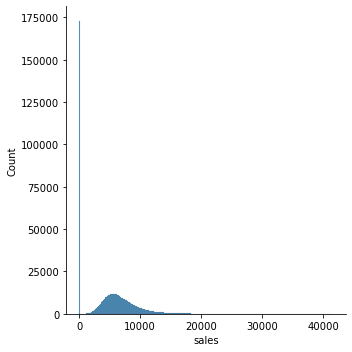

In [64]:
sns.displot( df1['sales'] )
#plt.rcParams['figure.figsize'] = (20, 10)

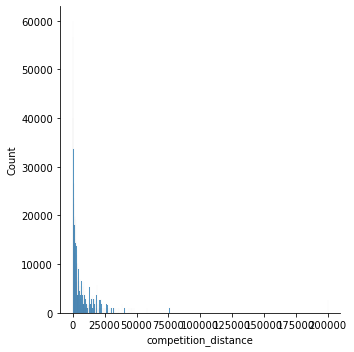

In [62]:
sns.displot( df1['competition_distance'] )

#plt.rcParams['figure.figsize'] = [ 2, 10 ] 

## 1.7.2. Categorical Attributes:

In [52]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='state_holiday', ylabel='sales'>

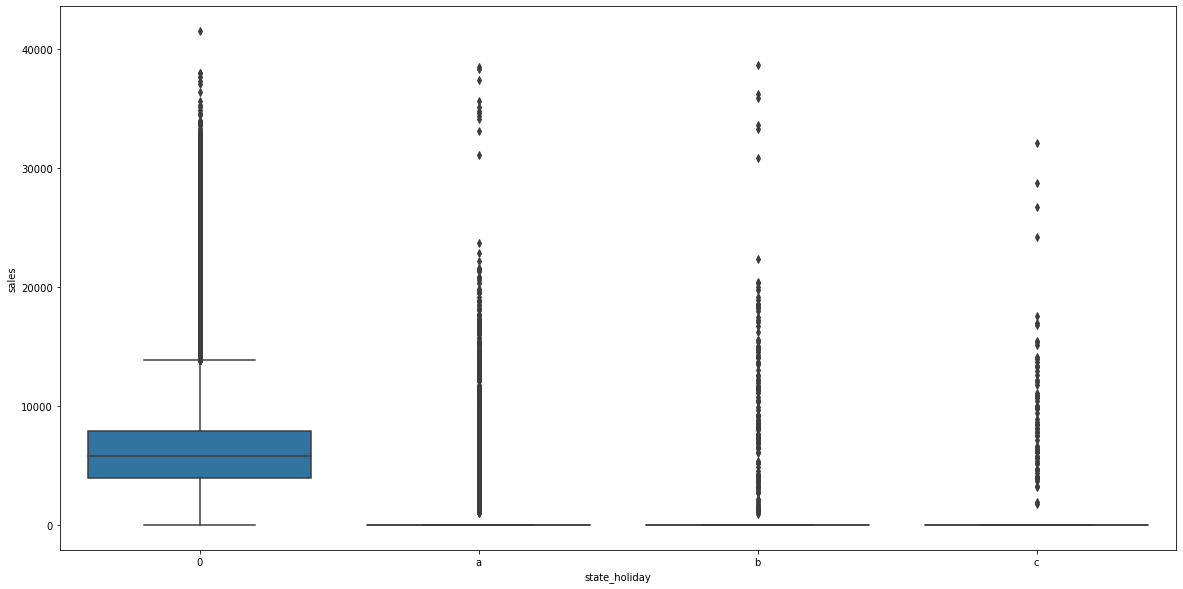

In [53]:
# state_holiday => 4

sns.boxplot( x ='state_holiday' , y ='sales', data = df1)

<AxesSubplot:xlabel='store_type', ylabel='sales'>

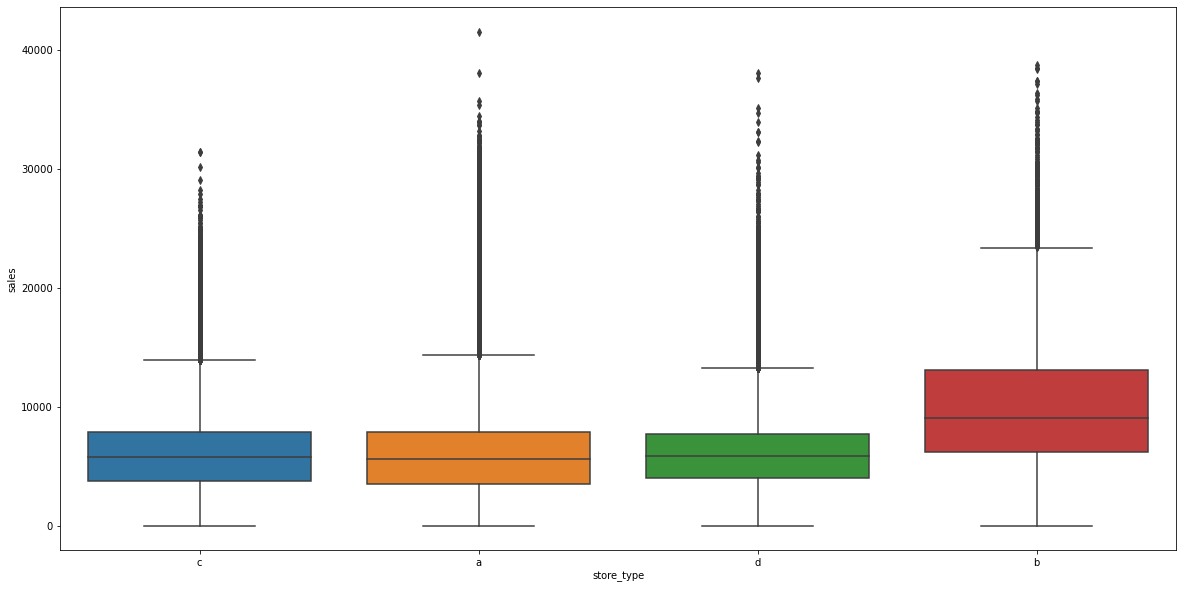

In [54]:
# store_type => 4

sns.boxplot( x='store_type', y='sales', data=df1)
#plt.rcParams["figure.size"]=(20,10)

<AxesSubplot:xlabel='assortment', ylabel='sales'>

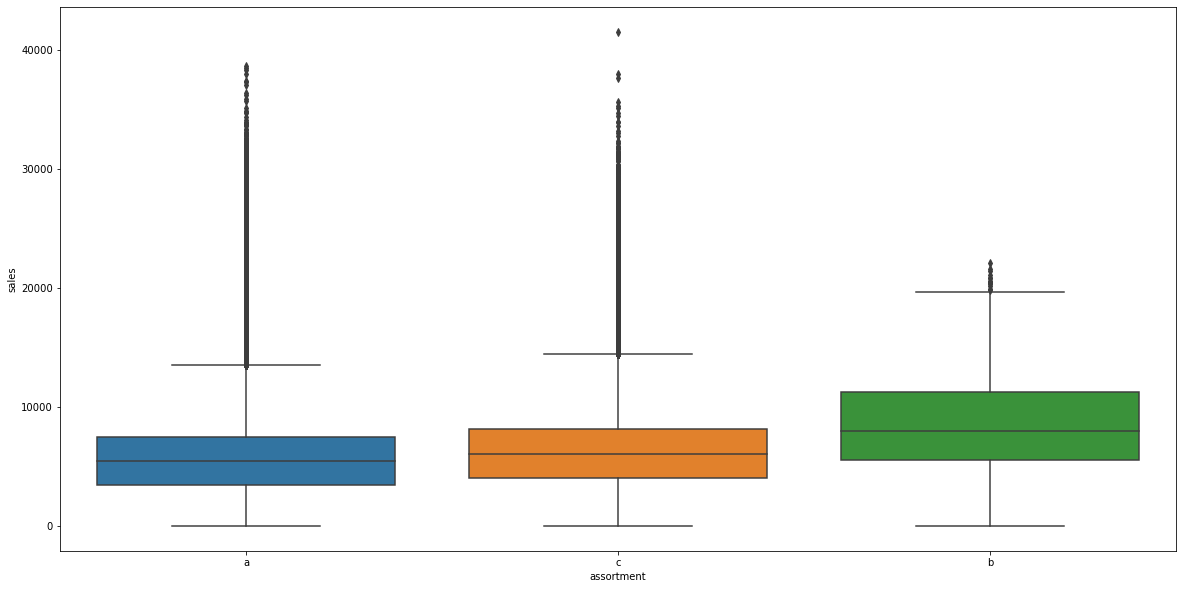

In [55]:
# assortment => 3

sns.boxplot( x='assortment', y='sales', data=df1)
#plt.rcParams["figure.size"]=(20,10)

<AxesSubplot:xlabel='promo_interval', ylabel='sales'>

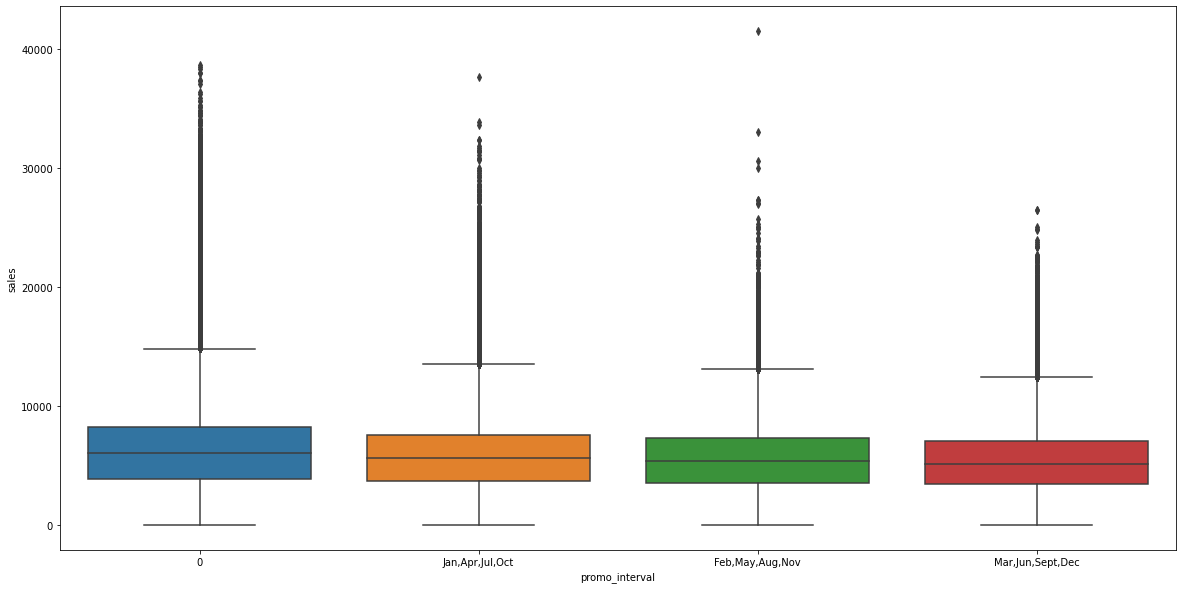

In [56]:
# promo_interval => 4

sns.boxplot(x='promo_interval', y='sales', data=df1)
#plt.rcParams["figure.size"]=(20,10)

<AxesSubplot:xlabel='month_map', ylabel='sales'>

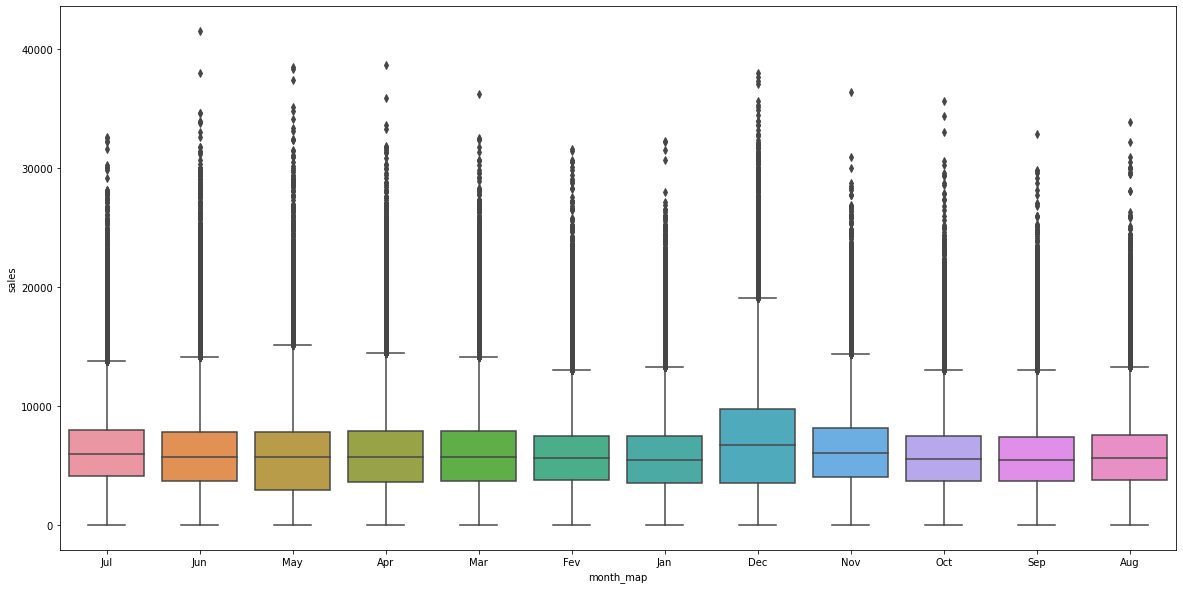

In [57]:
# month_map =>  12

sns.boxplot(x='month_map', y='sales', data=df1)
#plt.rcParams["figure.size"]=(20,10)

<AxesSubplot:xlabel='state_holiday', ylabel='sales'>

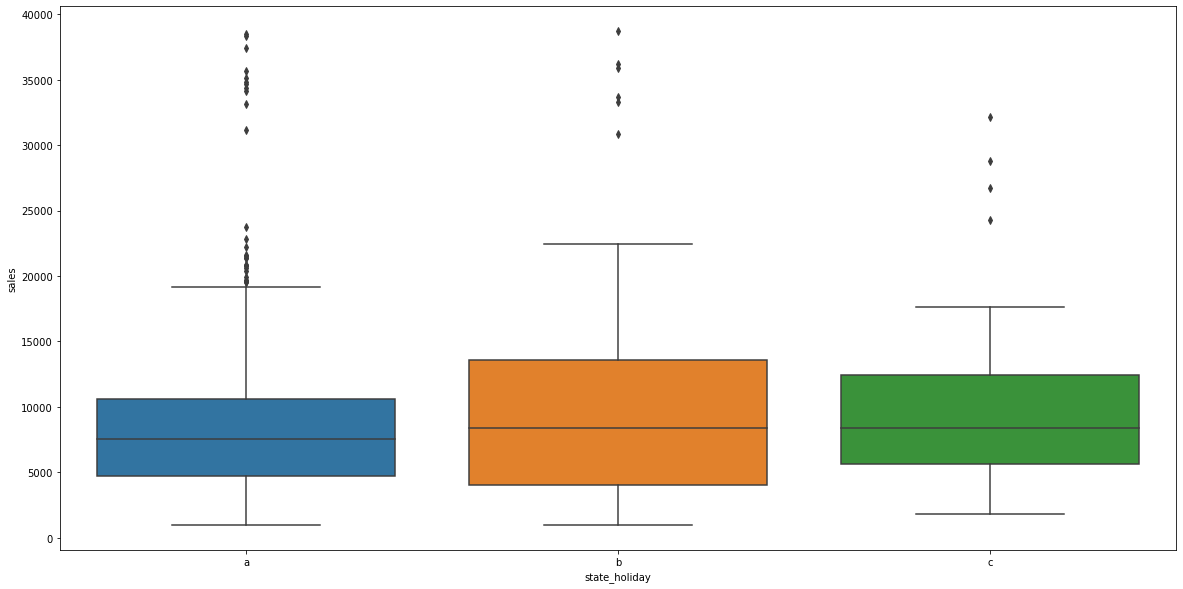

In [58]:
aux1 = df1[( df1['state_holiday' ] != '0' ) & (df1[ 'sales' ] > 0 ) ]

sns.boxplot( x = 'state_holiday', y = 'sales', data = aux1 )
#plt.rcParams["figure.size"]=(20,10)

<AxesSubplot:xlabel='store_type', ylabel='sales'>

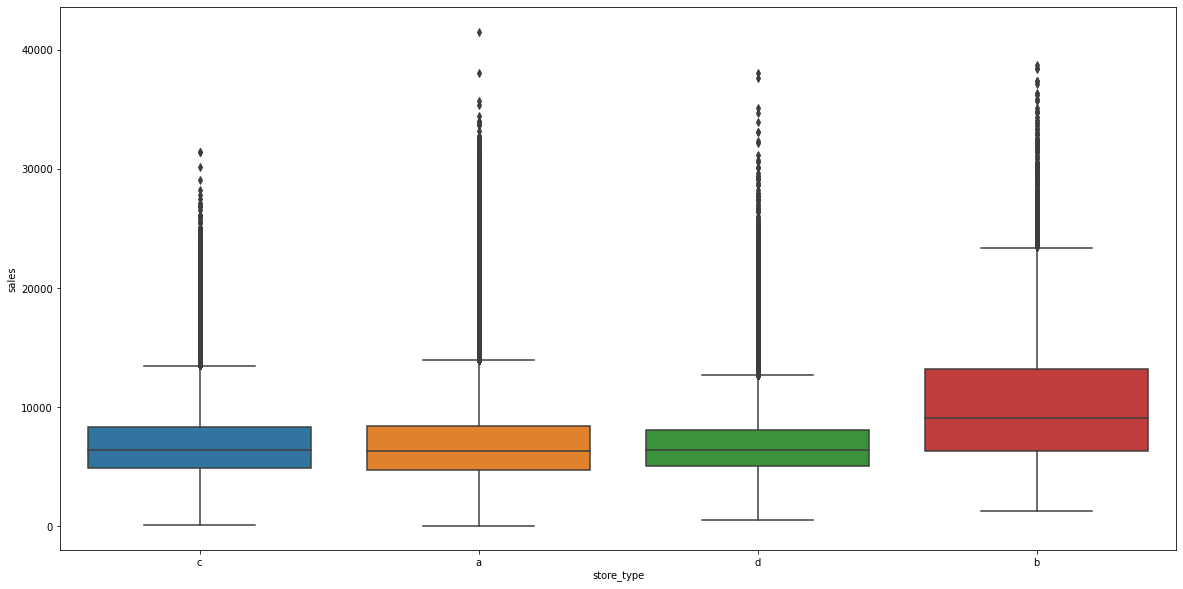

In [59]:
aux1 = df1[( df1[ 'store_type' ] != '0' ) & (df1[ 'sales' ] > 0 ) ]

sns.boxplot( x = 'store_type', y = 'sales', data = aux1 )
#plt.rcParams["figure.size"]=(20,10)

<AxesSubplot:xlabel='assortment', ylabel='sales'>

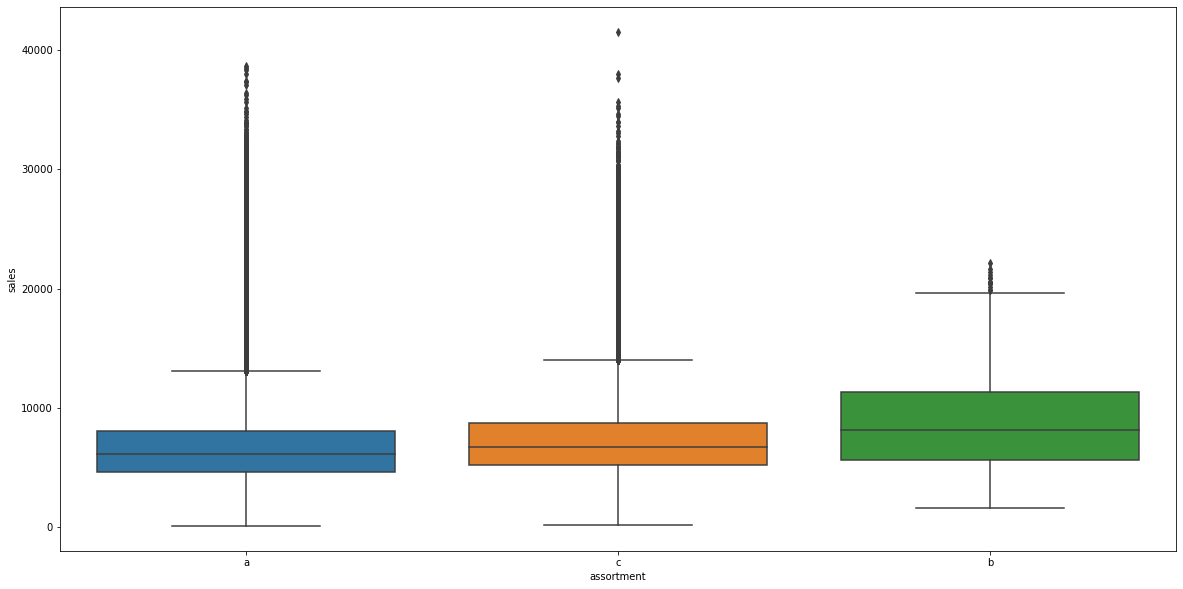

In [60]:
aux1 = df1[( df1[ 'assortment' ] != '0' ) & (df1[ 'sales' ] > 0 ) ]

sns.boxplot( x = 'assortment', y = 'sales', data = aux1 )
#plt.rcParams["figure.size"]=(20,10)

<AxesSubplot:xlabel='assortment', ylabel='sales'>

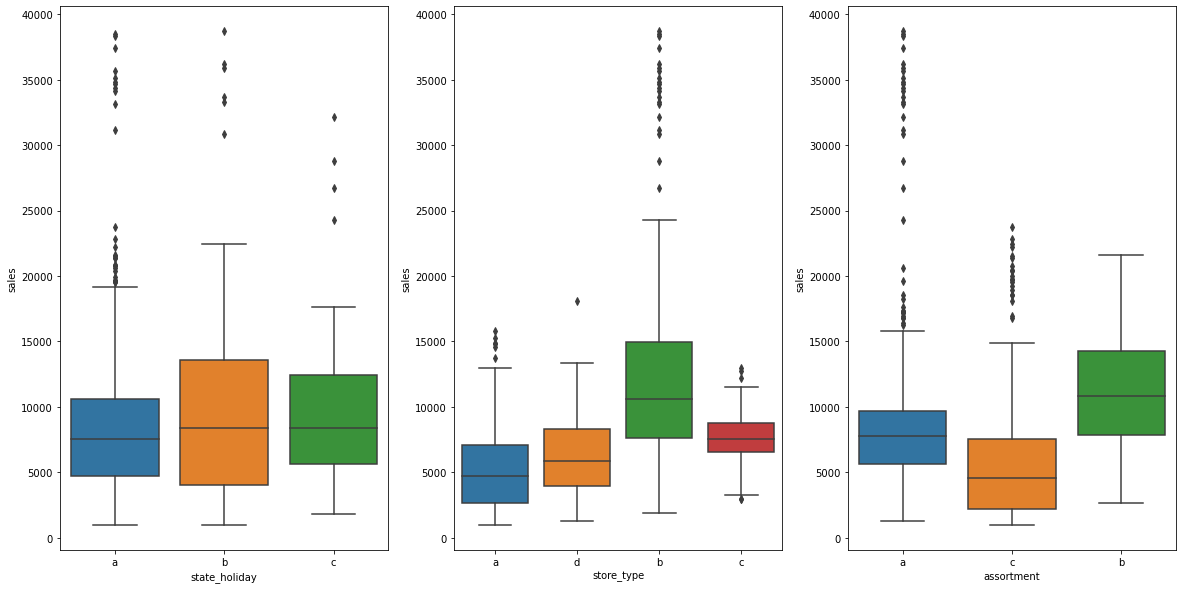

In [61]:
aux1 = df1[ ( df1['state_holiday'] !='0' ) & ( df1['sales'] > 0 ) ]

plt.subplot( 1, 3, 1 )
sns.boxplot( x='state_holiday', y='sales', data=aux1 )

plt.subplot( 1, 3, 2 )
sns.boxplot( x='store_type', y='sales', data=aux1 )

plt.subplot( 1, 3, 3 )
sns.boxplot( x='assortment', y='sales', data=aux1 )
#plt.rcParams["figure.size"]=(20,10)

# 2.0. PASSO 02 - FEATURE ENGINEERING:

In [65]:
df2 = df1.copy()

## 2.1. Mapa mental de hipóteses:

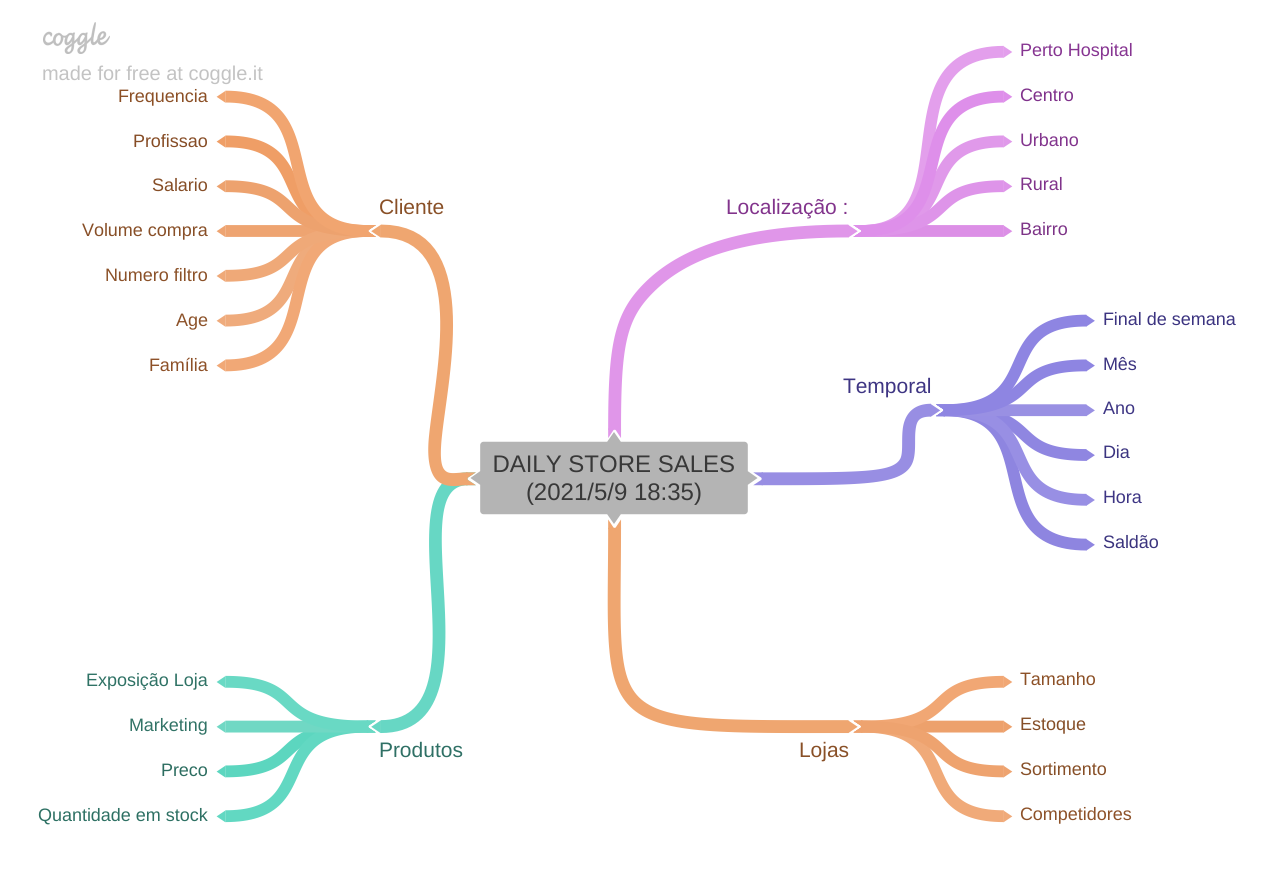

In [66]:
Image ( 'daily_store_map_image.png' )

## 2.2. Criação de hipóteses:

## 2.3. Lista final de hipóteses:

### 1) Lojas com maior sortimentos deveriam vender mais.
### 2) Lojas com competidores mais próximos deveriam vender menos.
### 3) Lojas com competidores à mais tempo deveriam vender mais.
### 4) Lojas com promoções ativas por amis tempo deveriam vender mais.
### 5) Lojas com mais dias de promoção deveriam vender mais.
### 6) Lojas com mais promoções consecutivas deveriam vender mais.
### 7) Lojas abertas durante o feriado de Natal deveriam vender mais.
### 8) Lojas deveriam vender mais ao longo dos anos.
### 9) Lojas deveriam vender mais no segundo semestre do ano.
### 10) Lojas deveriam vender mais depoois do dia 10 de cada mês.
### 11) Lojas deveriam ver menos aos finais de semana.
### 12) Lojas deveriam vender menos durante os feriados escolares.













In [67]:
# year:
df2['year'] = df2['date'].dt.year

# month:
df2['month'] = df2['date'].dt.month

# week of year:
df2['week_of_year'] = df2['date'].dt.weekofyear

# day
df2['day'] = df2['date'].dt.day

# year week:
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition since:
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year= x['competition_open_since_year'], month= x['competition_open_since_month'], day= 1 ), axis= 1 )

df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

# promo since:
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )

df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )

df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

# assortment:
# a = basic, b = extra, c = extendend

df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x =='b' else 'extendend' )

# state holiday:
# a = public holiday, b = Easter holiday, c = Christmas 

df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )


In [73]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


## 3.0. FILTRAGEM DE DADOS:

In [74]:
df3 = df2.copy()

In [75]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,week_of_year,day,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


# 3.0. PASSO 03 - FILTRAGEM DE VARIAVEIS

In [76]:
df3 = df3[( df3['open'] != 0 ) & ( df3['sales'] > 0 )]

## 3.2. Seleção das colunas:

In [77]:
cols_drop = ['customers', 'open','promo_interval','month_map']
df3 = df3.drop( cols_drop, axis=1 )

In [78]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'week_of_year', 'day', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0. PASSO 04 - ANALISE EXPLORATORIA DE DADOS:

In [79]:
df4 = df3.copy()

In [80]:
df4

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,is_promo,year,month,week_of_year,day,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extendend,620.0,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,682,2,2013-01-01,3375,0,public_holiday,1,b,basic,150.0,...,0,2013,1,1,1,2013-00,2006-09-01,77,2012-12-31,0
1016827,733,2,2013-01-01,10765,0,public_holiday,1,b,extra,860.0,...,0,2013,1,1,1,2013-00,1999-10-01,161,2012-12-31,0
1016863,769,2,2013-01-01,5035,0,public_holiday,1,b,extra,840.0,...,1,2013,1,1,1,2013-00,2013-01-01,0,2012-11-19,6
1017042,948,2,2013-01-01,4491,0,public_holiday,1,b,extra,1430.0,...,0,2013,1,1,1,2013-00,2013-01-01,0,2012-12-31,0


## 4.1. Analise Univariada:

## 4.1.1. Response Variable:

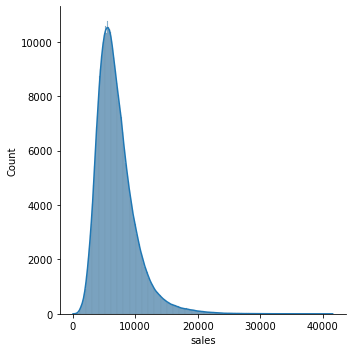

In [81]:
sns.displot( df4[ 'sales' ], kde= True )
#plt.rcParams["figure.size"]=(20,10)

## 4.1.2. Numerical Variable:

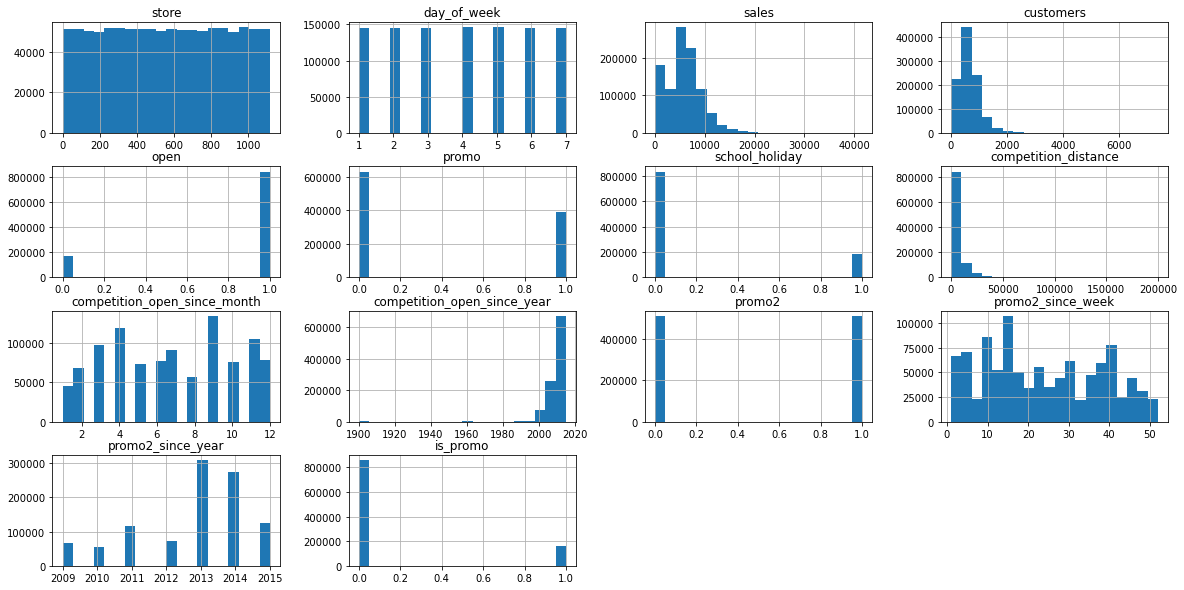

In [82]:
num_attributes.hist(bins=20);
#plt.rcParams["figure.size"]=(10,10)


## 4.1.3. Categorical Variable:

In [83]:
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


ValueError: num must be 1 <= num <= 4, not 6

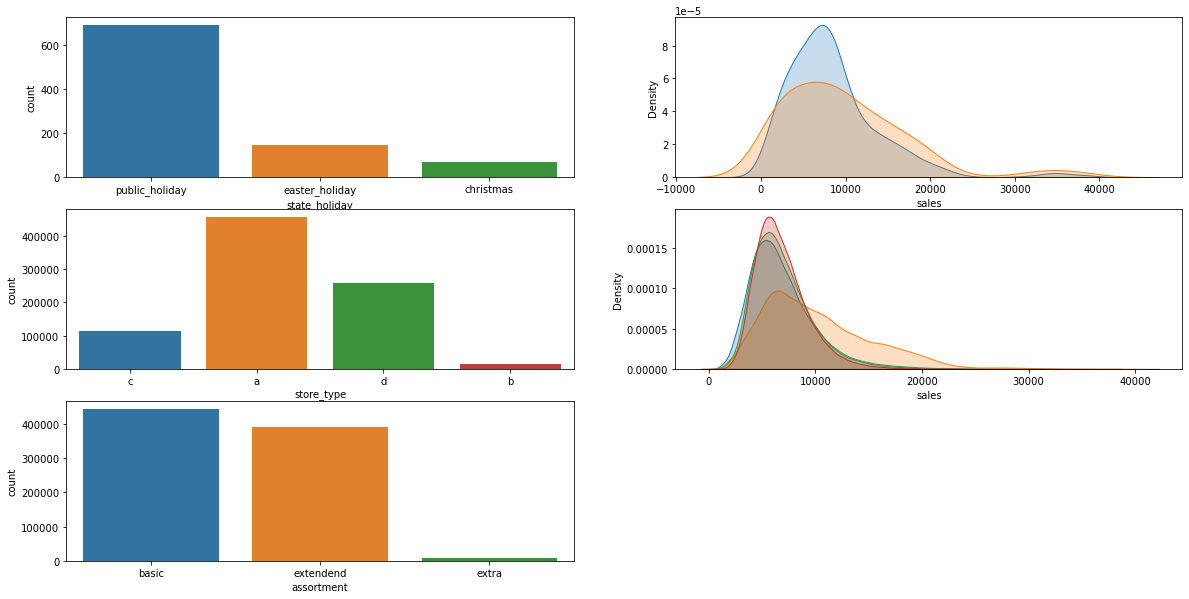

In [84]:
df4['state_holiday'].drop_duplicates()

# state holiday:

plt.subplot( 3, 2, 1 )
a = df4[ df4['state_holiday'] != 'regular_day' ]
sns.countplot( a['state_holiday'] )

plt.subplot( 3, 2, 2 )
sns.kdeplot( df4[ df4['state_holiday'] == 'public_holiday']   ['sales'], label='public_holiday',    shade=True )
sns.kdeplot( df4[ df4['state_holiday'] == 'easter_holiday']   ['sales'], label='easter_holiday',    shade=True )
sns.kdeplot( df4[ df4['state_holiday'] == 'chrstimas_holiday']['sales'], label='chrstimas_holiday', shade=True )


# story type:

plt.subplot( 3, 2, 3 )
sns.countplot( df4['store_type'])

plt.subplot( 3, 2, 4 )
sns.kdeplot( df4[ df4['store_type'] == 'a']['sales'], label='a', shade=True )
sns.kdeplot( df4[ df4['store_type'] == 'b']['sales'], label='b', shade=True )
sns.kdeplot( df4[ df4['store_type'] == 'c']['sales'], label='c', shade=True )
sns.kdeplot( df4[ df4['store_type'] == 'd']['sales'], label='d', shade=True )


# assortment:

plt.subplot( 3, 2, 5 )
sns.countplot( df4['assortment'])

plt.subplot( 2, 2, 6 )
sns.kdeplot( df4[ df4['assortment'] == 'a']['sales'], label='extended', shade=True )
sns.kdeplot( df4[ df4['assortment'] == 'b']['sales'], label='basic',    shade=True )
sns.kdeplot( df4[ df4['assortment'] == 'c']['sales'], label='extra',    shade=True )
#plt.rcParams["figure.size"]=(1,5)



## 4.2. Analise Bivariada:

### H1. Lojas com maior sortimentos deveriam vender mais:
**FALSA** Lojas com MAIOR SORTMENTO vendem MENOS.

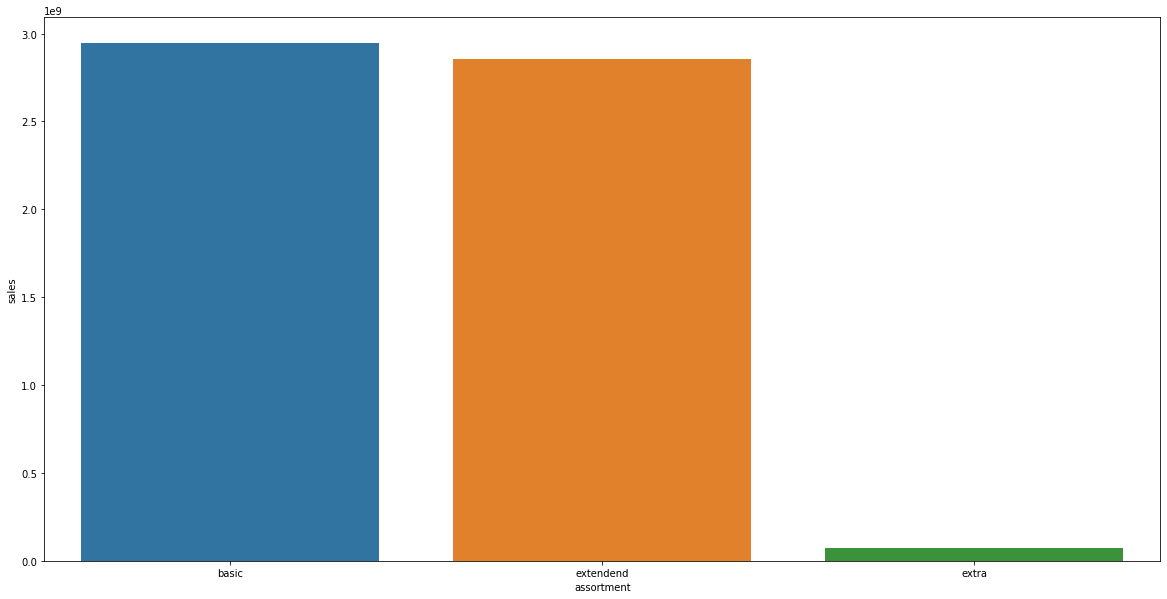

In [85]:
aux1 = df4[['assortment', 'sales']].groupby( 'assortment' ).sum().reset_index()
sns.barplot( x = 'assortment', y='sales', data = aux1 );

<AxesSubplot:xlabel='year_week'>

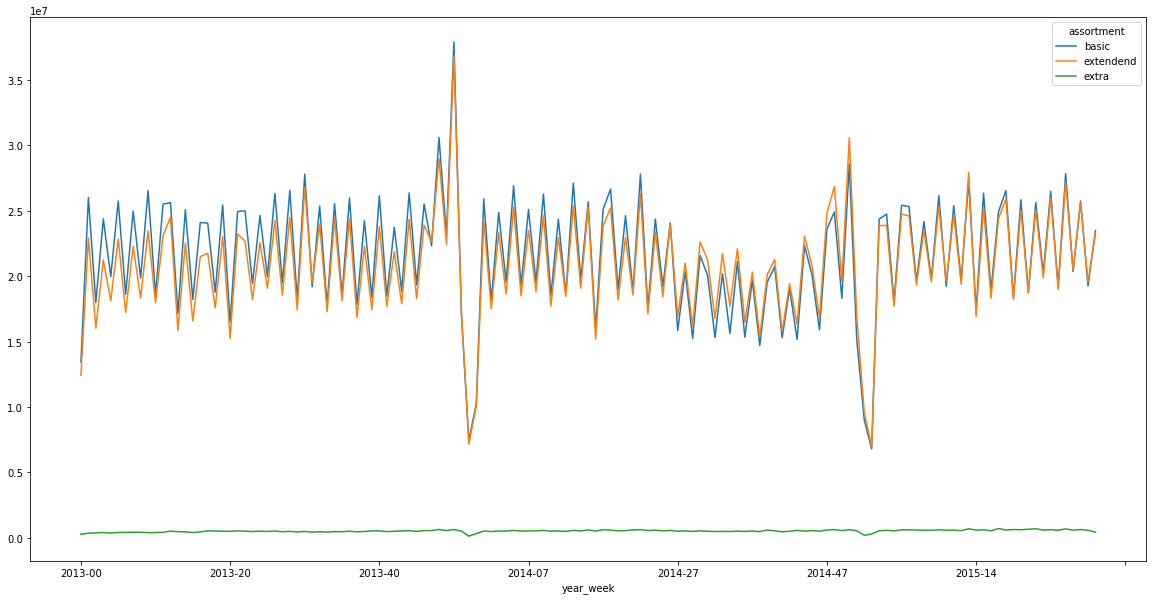

In [86]:
aux2 = df4[['assortment', 'sales', 'year_week']].groupby( [ 'year_week', 'assortment' ] ).sum().reset_index()
aux2.pivot( index = 'year_week', columns ='assortment', values ='sales' ).plot()

In [ ]:
aux3 =  aux2[ aux2['assortment'] == 'extra' ]
aux3.pivot( index = 'year_week', columns ='assortment', values = 'sales' ).plot()

### H2. Lojas com competidores mais próximos deveriam vender menos.
**FALSA** Lojas com COMPETIDORES MAIS PRÓXIMOS vendem MAIS.

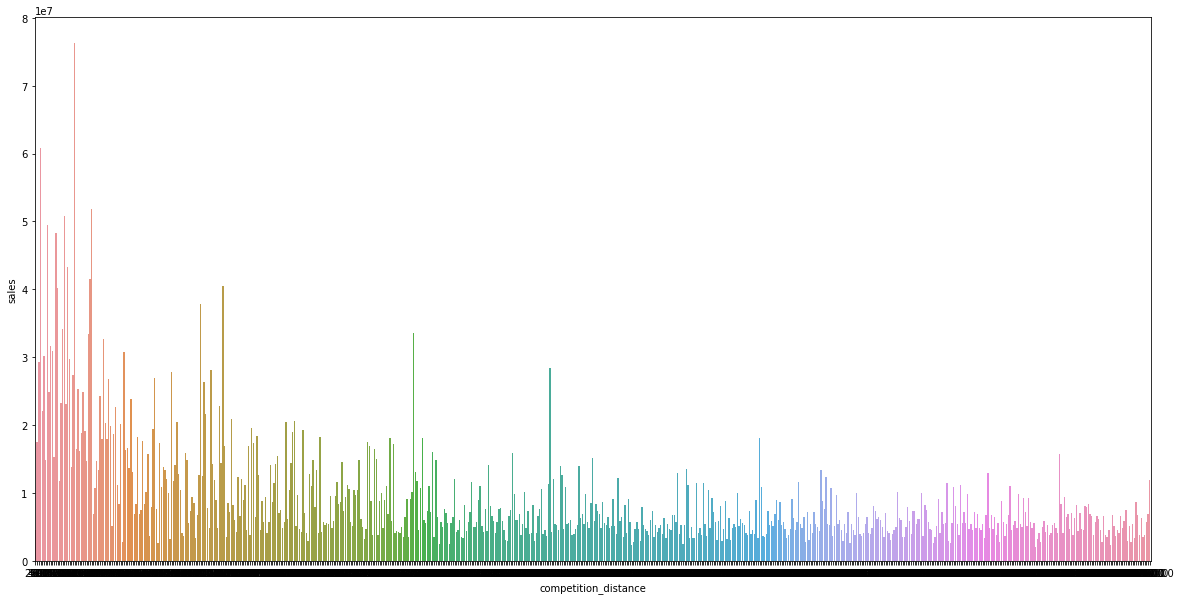

In [87]:
aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()
sns.barplot( x = 'competition_distance', y = 'sales', data = aux1 );

In [88]:
aux1.sample(4)

,competition_distance,sales
234,2880.0,3574303
203,2330.0,10024132
40,420.0,32679553
71,730.0,7585401


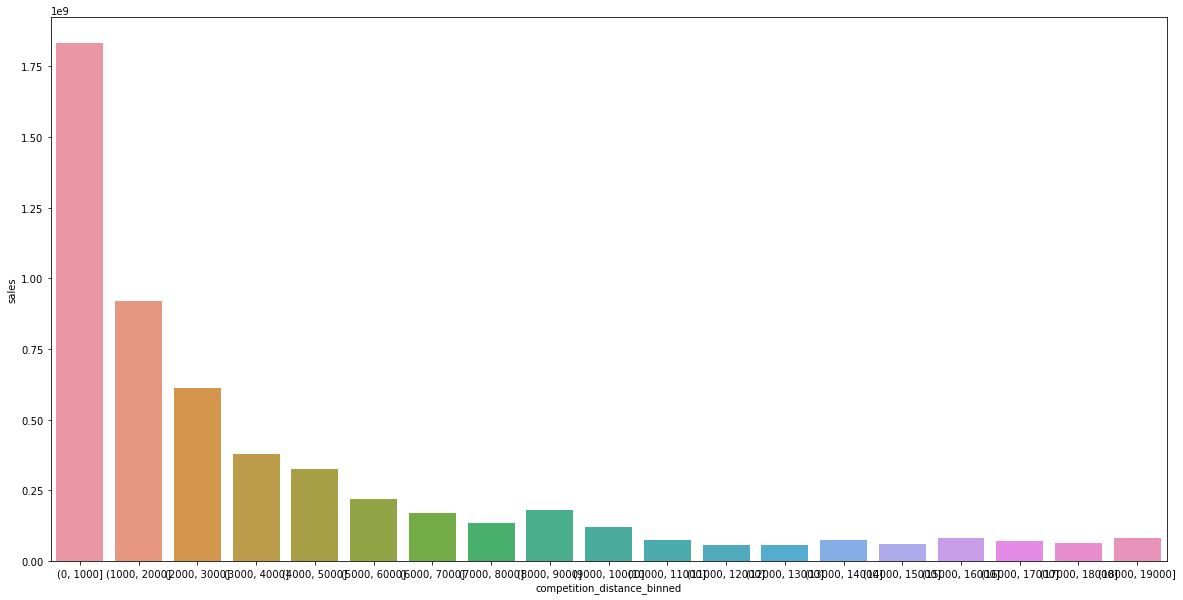

In [89]:
aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()

bins = list( np.arange(0, 20000, 1000) )

aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins )
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned' ).sum().reset_index()

sns.barplot( x='competition_distance_binned', y='sales', data=aux2 );

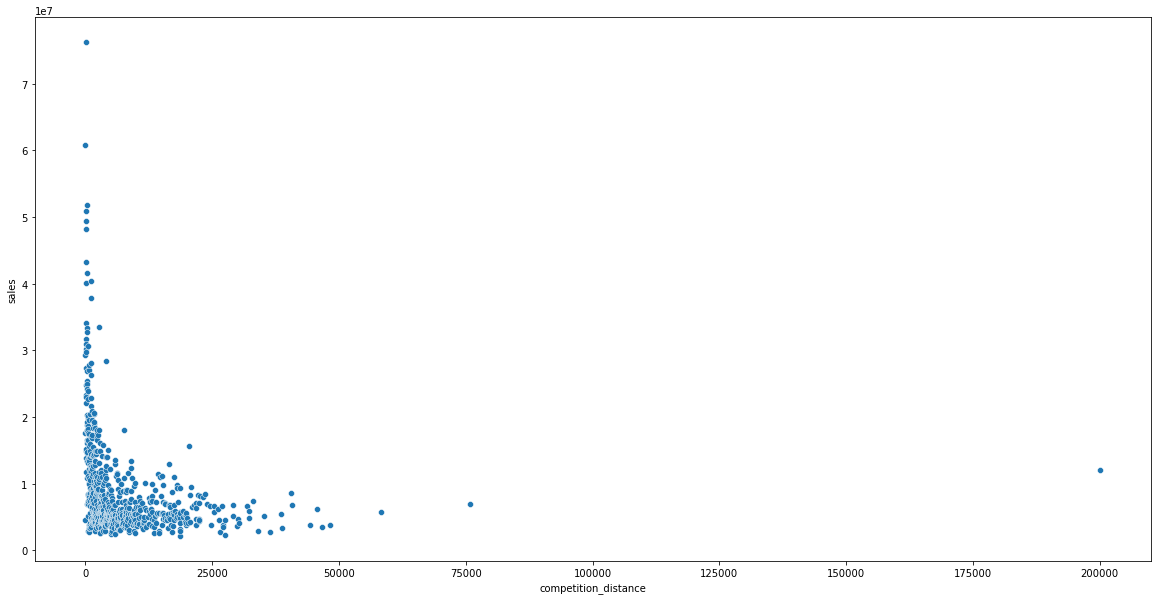

In [90]:
aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()

sns.scatterplot( x ='competition_distance', y='sales', data=aux1 );

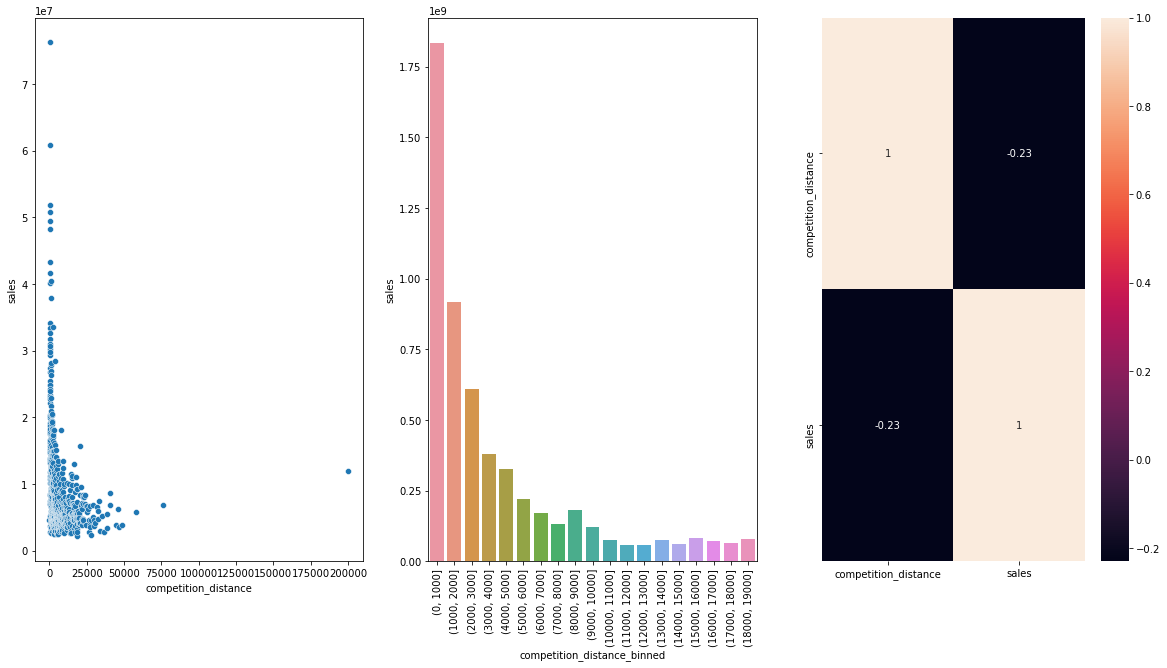

In [91]:
aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()

plt.subplot( 1, 3, 1)
sns.scatterplot( x ='competition_distance', y='sales', data=aux1 )

plt.subplot( 1, 3, 2)
sns.scatterplot( x ='competition_distance', y='sales', data=aux1 )
bins = list( np.arange(0, 20000, 1000) )
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins )
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned' ).sum().reset_index()
sns.barplot( x='competition_distance_binned', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 3)
sns.heatmap( aux1.corr( method='pearson' ), annot=True );




### H3. Lojas com competidores á mais tempo deveriam vender  mais.
**FALSA** Lojas com COMPETIDORES A MAIS TEMPO vendem MENOS.

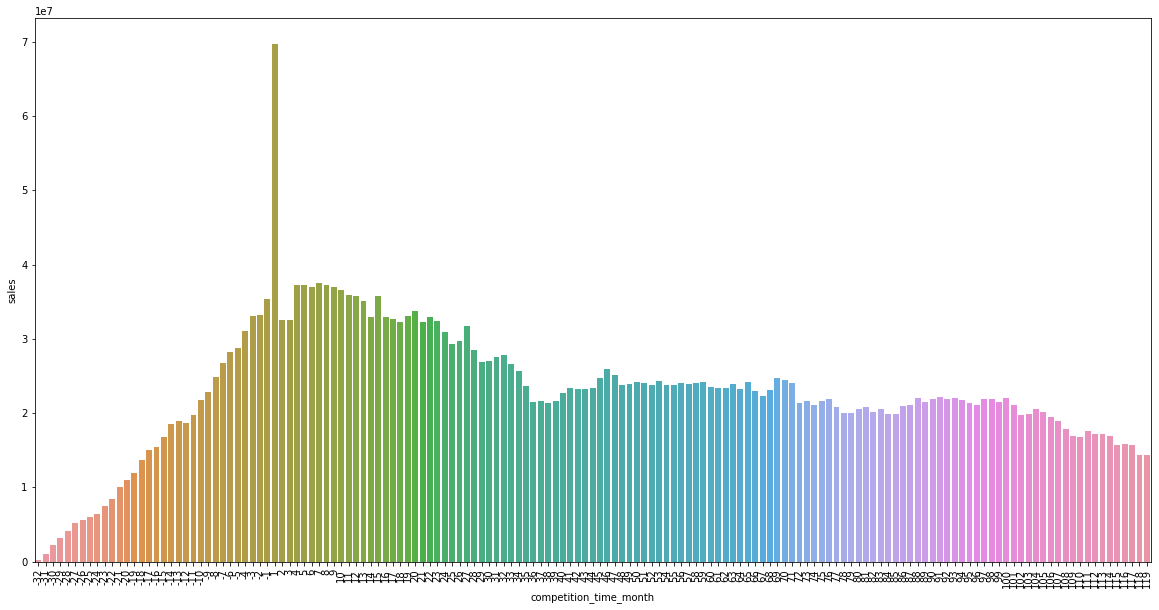

In [92]:
aux1 = df4[['competition_time_month', 'sales']].groupby( 'competition_time_month' ).sum().reset_index()
aux2 = aux1[( aux1['competition_time_month'] < 120 ) & ( aux1['competition_time_month'] != 0 )]

sns.barplot( x='competition_time_month', y='sales', data=aux2 );
plt.xticks( rotation=90);

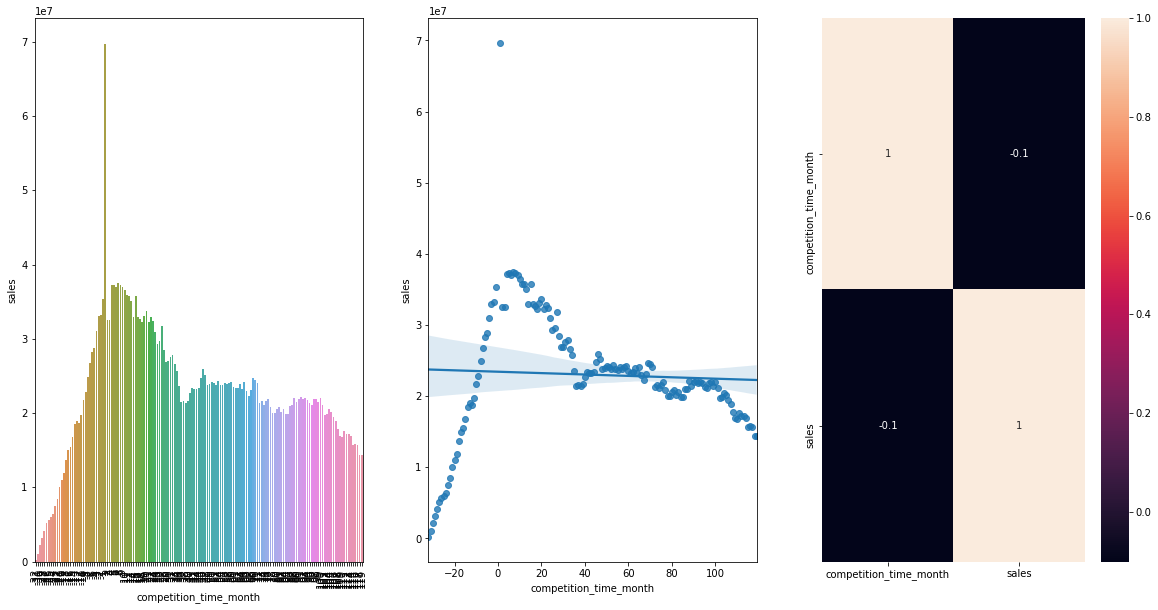

In [93]:
plt.subplot( 1, 3, 1 )
aux1 = df4[['competition_time_month', 'sales']].groupby( 'competition_time_month' ).sum().reset_index()
aux2 = aux1[( aux1['competition_time_month'] < 120 ) & ( aux1['competition_time_month'] != 0 )]

sns.barplot( x='competition_time_month', y='sales', data=aux2 );
plt.xticks( rotation=90);

plt.subplot( 1, 3, 2 )
sns.regplot( x='competition_time_month', y='sales', data=aux2 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson'), annot=True );

### H4. Lojas com promoções ativas por mais tempo deveriam vender mais.
**FALSA** Lojas com promoçoes ativas por mais tempo vendem menos, depois de um certo período.

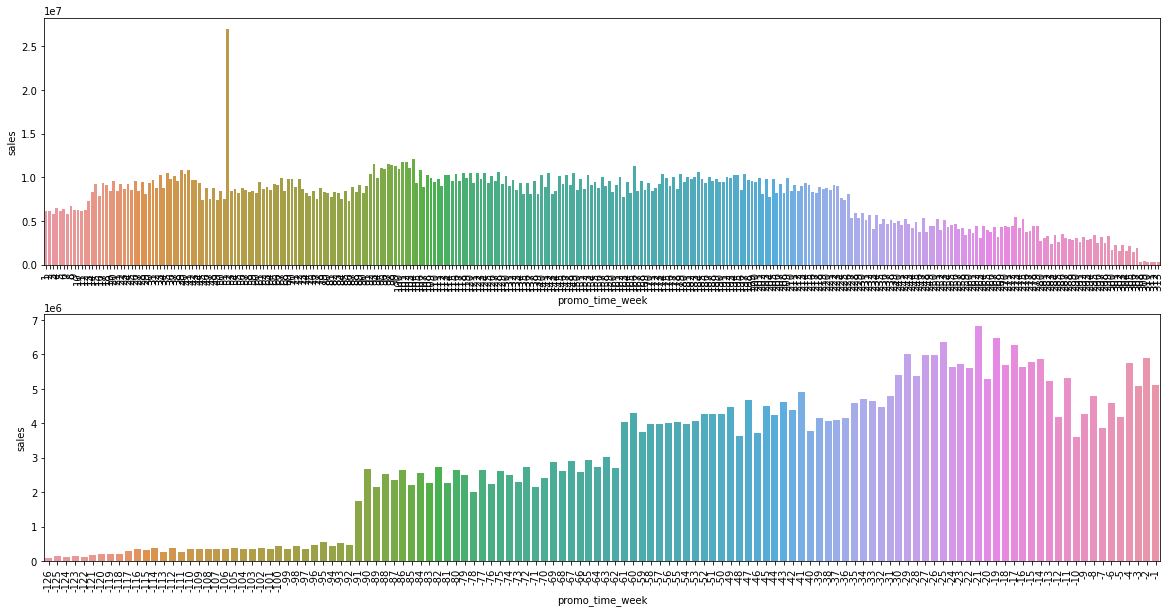

In [94]:
aux1 = df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()

sns.barplot( x='promo_time_week', y='sales', data=aux1 );

plt.subplot(2, 1, 1)
aux2 = aux1[aux1['promo_time_week'] > 0 ] # promo extendido
sns.barplot( x='promo_time_week', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot(2, 1, 2)
aux3 = aux1[aux1['promo_time_week'] < 0 ] # promo regular
sns.barplot( x='promo_time_week', y='sales', data=aux3 );
plt.xticks( rotation=90 );

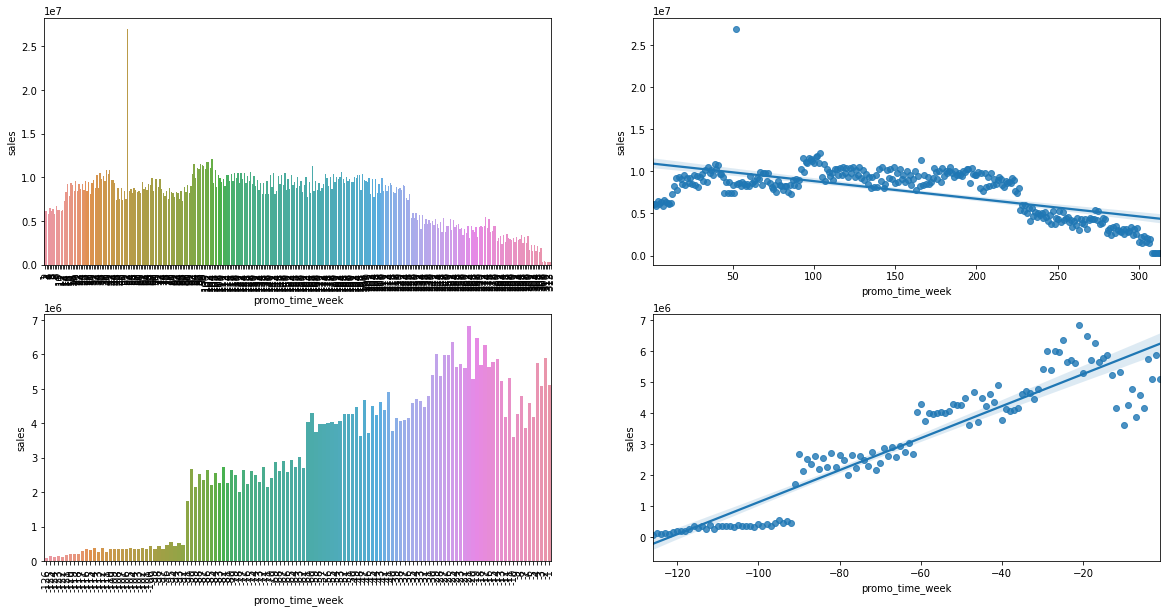

In [95]:
aux1 = df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()

sns.barplot( x='promo_time_week', y='sales', data=aux1 );

plt.subplot( 2, 2, 1)
aux2 = aux1[aux1['promo_time_week'] > 0 ] # promo extendido
sns.barplot( x='promo_time_week', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( 2, 2, 2 )
sns.regplot(x='promo_time_week', y='sales', data=aux2);

plt.subplot(2, 2, 3 )
aux3 = aux1[aux1['promo_time_week'] < 0 ] # promo regular
sns.barplot( x='promo_time_week', y='sales', data=aux3 );
plt.xticks( rotation=90 );

plt.subplot( 2, 2, 4 )
sns.regplot( x='promo_time_week', y='sales', data=aux3 );

In [96]:
import matplotlib.gridspec as gridspec

In [97]:
aux1 = df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()

grid = gridSpec(2,3)

plt.subplot(grid[0,0] )
aux2 = aux1[aux1['promo_time_week'] > 0 ] # promo extendido
sns.barplot( x='promo_time_week', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( grid[0,1] )
sns.regplot(x='promo_time_week', y='sales', data=aux2);

plt.subplot( grid[1,0] )
aux3 = aux1[aux1['promo_time_week'] < 0 ] # promo regular
sns.barplot( x='promo_time_week', y='sales', data=aux3 );
plt.xticks( rotation=90 );

plt.subplot(grid[1,1] )
sns.regplot(x='promo_time_week', y='sales', data=aux3)

plt.subplot( grid[:,2] )
sns.heatmap( aux1.corr(method='person' ), annot=True );

TypeError: 'module' object is not callable

### H6 Lojas com mais promoções consecutivas deveriam vender mais.
**FALSA Lojas com promoções consecutivas vendem menos.**

In [98]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


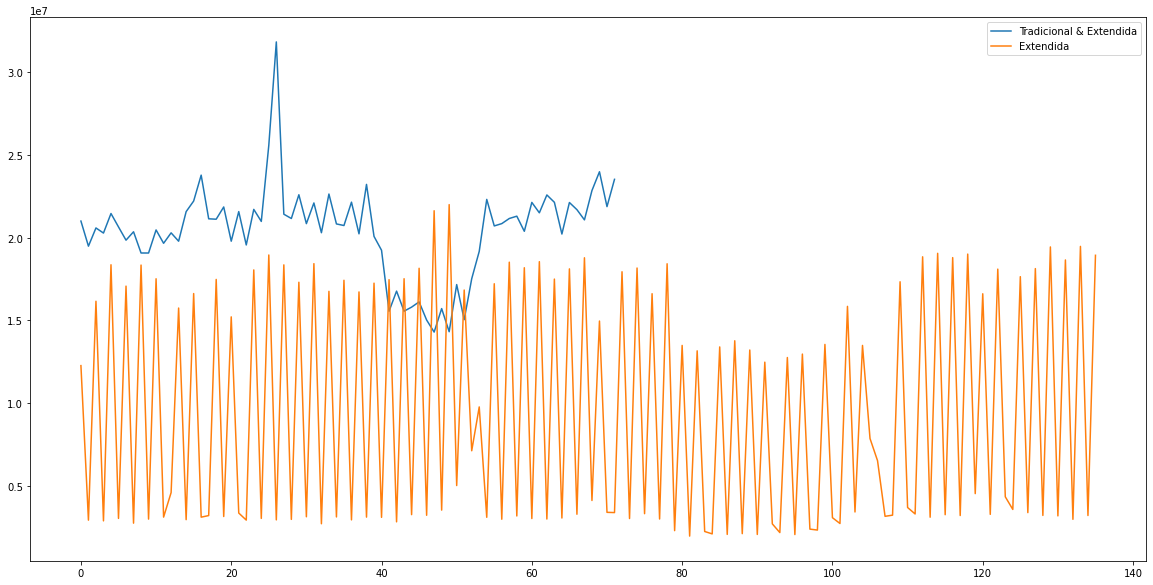

In [99]:
aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[( df4['promo'] == 0 ) & ( df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax = ax)
ax.legend(labels=['Tradicional & Extendida', 'Extendida']);

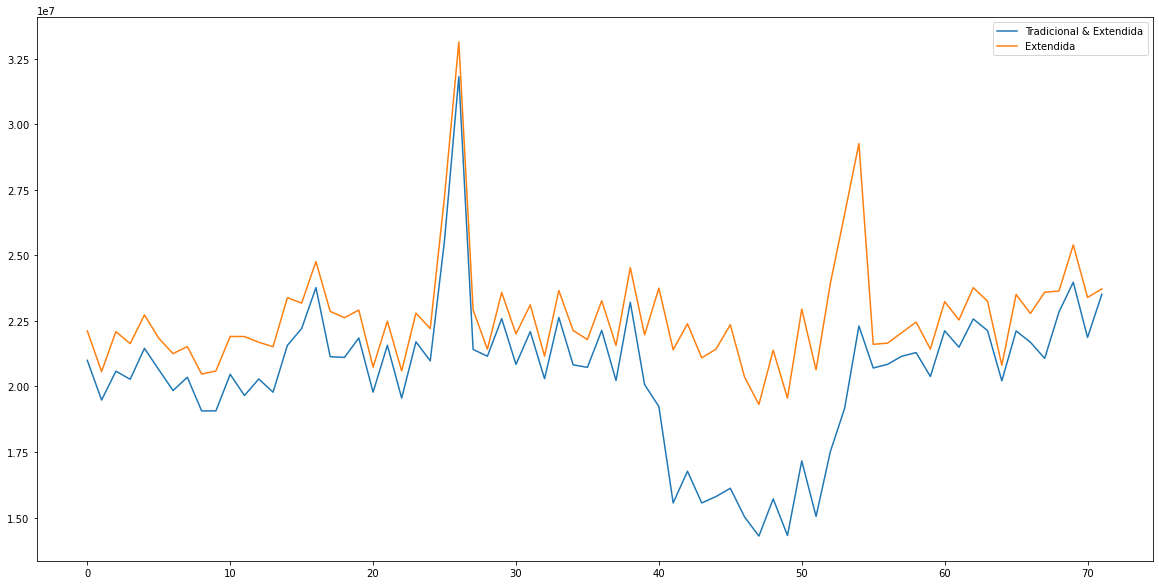

In [100]:
aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax = ax)
ax.legend( labels = ['Tradicional & Extendida', 'Extendida']);

### H7 Lojas abertas durante o feriado de Natal deveriam vender mais.
**FALSA Lojas abertas durante o feriado de Natal vendem menos.

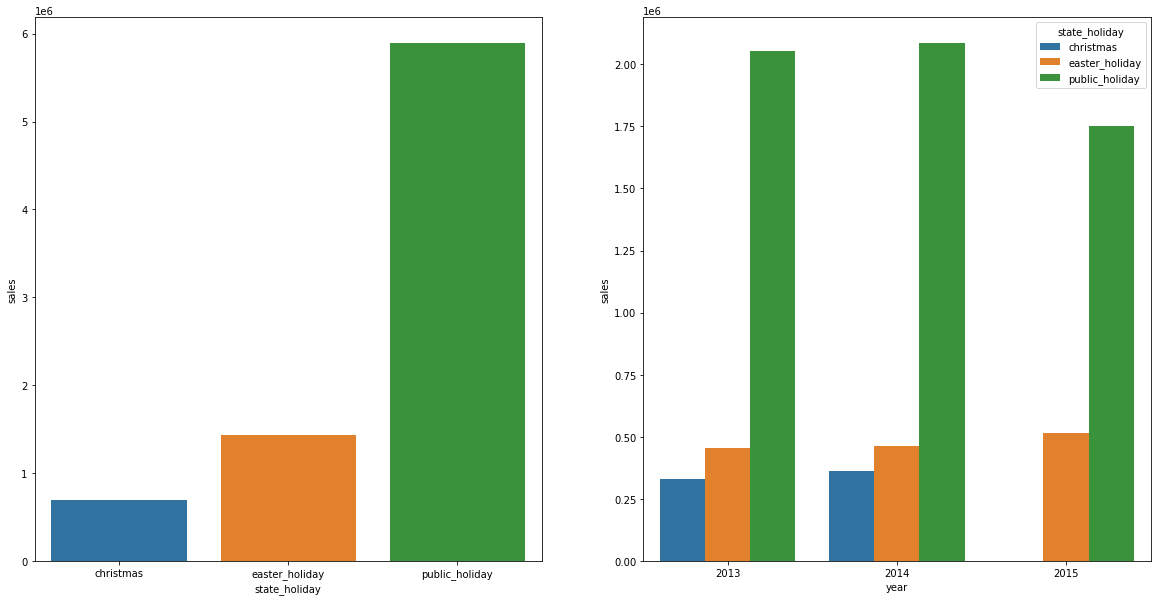

In [101]:
aux = df4[df4['state_holiday']!= 'regular_day']

plt.subplot( 1, 2, 1 )
aux1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday' ).sum().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1);

plt.subplot( 1, 2, 2 )
aux2 = aux[['year','state_holiday','sales']].groupby( ['year','state_holiday'] ).sum().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday',data=aux2);

### H8 Lojas deveriam vender mais ao longo dos anos.
**FALSALojas vendem menos ao longo dos anos.

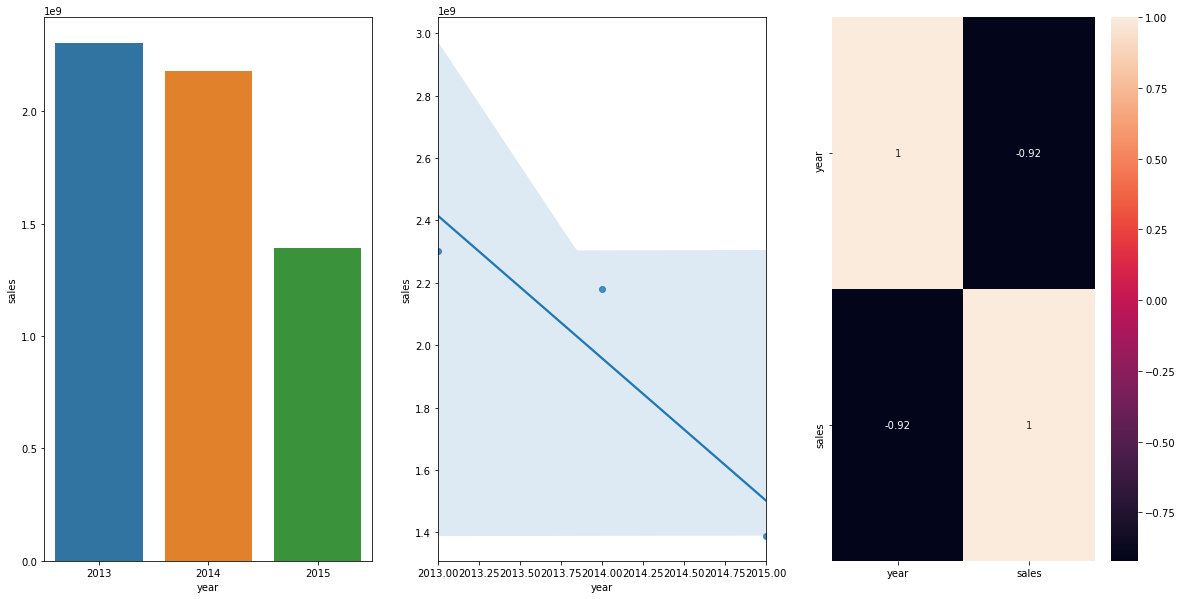

In [102]:
plt.subplot( 1, 3, 1)
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()
sns.barplot( x='year', y='sales', data=aux1);

plt.subplot( 1, 3, 2)
sns.regplot(x='year', y='sales', data=aux1);

plt.subplot( 1, 3, 3)
sns.heatmap( aux1.corr(method='pearson'), annot=True);

### H9 Lojas deveriam vender mais no segundo semestre do ano.
**FALSA Lojas vendem menos no segundo semestre.**

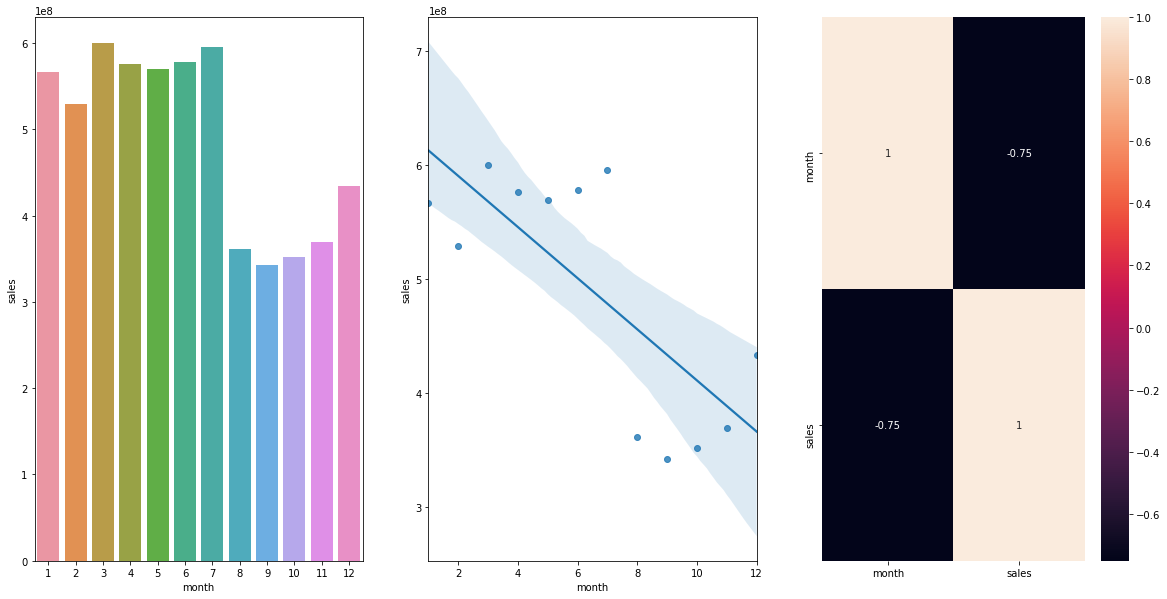

In [103]:
plt.subplot( 1, 3, 1 )
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()
sns.barplot(x='month', y='sales', data=aux1);

plt.subplot( 1, 3, 2 )
sns.regplot(x='month', y='sales', data=aux1);

plt.subplot( 1, 3, 3 )
sns.heatmap(aux1.corr(method='pearson'), annot=True );

### H10 Lojas deveriam vender mais depois do dia 10 de cada mês.
**VERDADEIRA** Lojas vendem mais após 10 primeiros dias de cada mês.


<AxesSubplot:xlabel='before_after', ylabel='sales'>

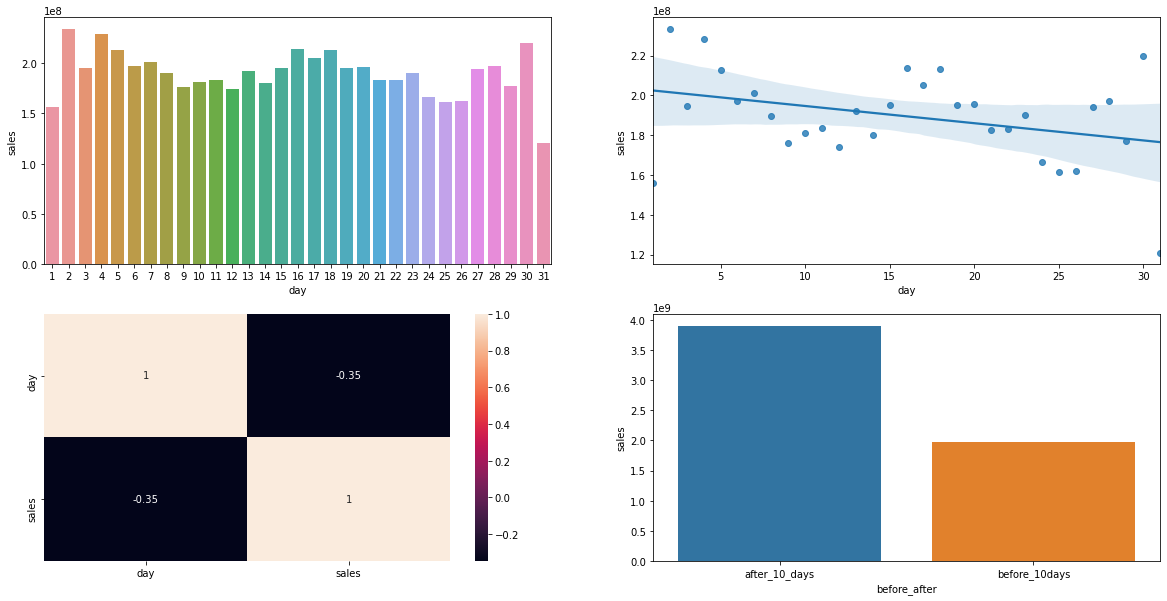

In [104]:
plt.subplot( 2, 2, 1 )
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()
sns.barplot( x='day', y='sales', data= aux1 );

plt.subplot( 2, 2, 2 )
sns.regplot( x='day', y='sales', data= aux1 );

plt.subplot( 2, 2, 3 )
sns.heatmap( aux1.corr(method ='pearson'), annot=True )

plt.subplot( 2, 2, 4 )
aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10days' if x<= 10 else 'after_10_days' )
aux2 = aux1[['before_after', 'sales']].groupby( 'before_after' ).sum().reset_index()
sns.barplot(x='before_after', y='sales', data=aux2)

### H11 Lojas deveriam ver menos aos finais de semana.
**VERDADEIRA Lojas vendem menos aos finais de semana.

<AxesSubplot:>

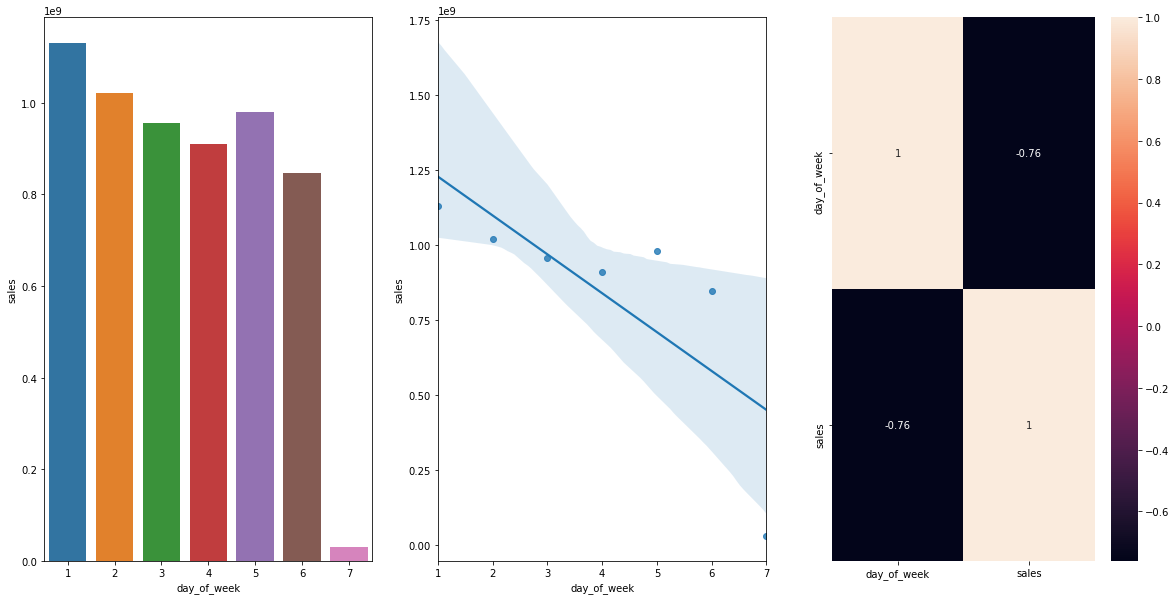

In [105]:
plt.subplot( 1, 3, 1 )
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()
sns.barplot( x='day_of_week', y='sales', data=aux1 )

plt.subplot( 1, 3, 2 )
sns.regplot( x='day_of_week', y='sales', data=aux1 )

plt.subplot( 1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True )

### H12 Lojas deveriam vender menos durante os feriados escolares.


<AxesSubplot:xlabel='month', ylabel='sales'>

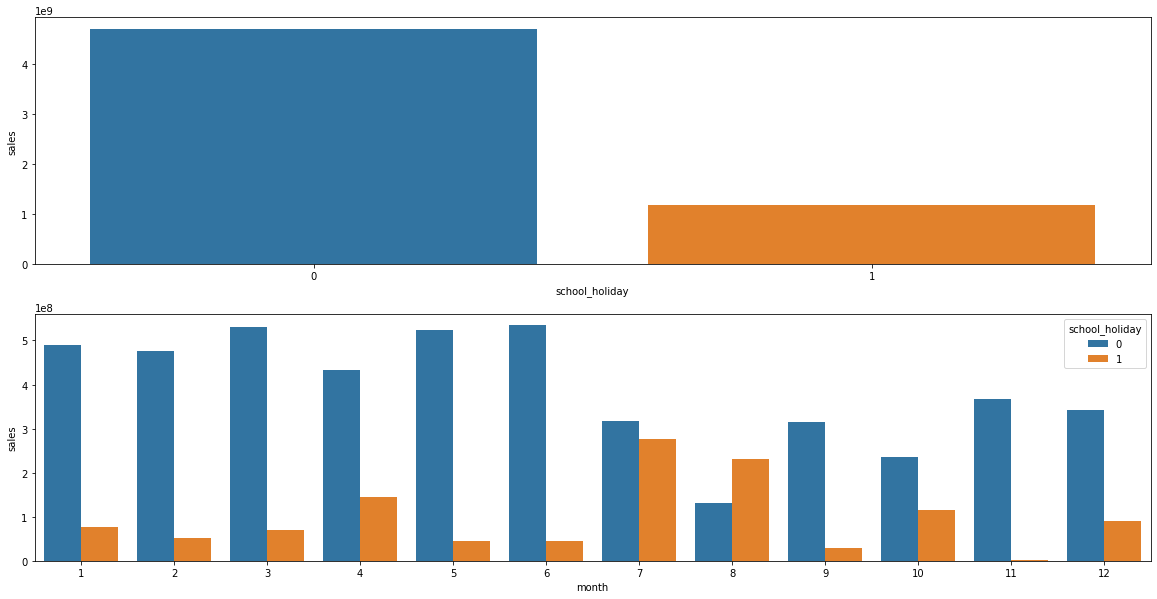

In [106]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()

plt.subplot( 2, 1, 1 )
sns.barplot( x='school_holiday', y='sales', data=aux1 )


aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
plt.subplot( 2, 1, 2 )
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2 )                                                   

In [107]:
from tabulate import tabulate

In [108]:
tab = [['Hipoteses', 'Conclusao', 'Relevancia'], 
      ['H1', 'Falsa', 'Baixa'],
      ['H2', 'Falsa', 'Media'],
      ['H3', 'Falsa', 'Media'],
      ['H4', 'Falsa', 'Baixa'],
      ['H5', '-','-'],
      ['H6', 'Falsa', 'Baixa'],
      ['H7', 'Falsa', 'Baixa'],
      ['H8', 'Falsa', 'Media'],
      ['H9', 'Falsa', 'Media'],
      ['H10', 'Falsa', 'Alta'],
      ['H11', 'Verdadeira', 'Alta'],
      ['H12', 'Verdadeira', 'Alta'],
      ['H13', 'Verdadeira', 'Alta'],
      ]
print( tabulate(tab, headers='firstrow') )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Baixa
H8           Falsa        Media
H9           Falsa        Media
H10          Falsa        Alta
H11          Verdadeira   Alta
H12          Verdadeira   Alta
H13          Verdadeira   Alta


## 4.3. Analise Multivariada:

## 4.3.1. Numerical Attributes

In [109]:
num_attributes.head()

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
0,1,5,5263,555,1,1,1,1270.0,9,2008,0,31,2015,0
1,2,5,6064,625,1,1,1,570.0,11,2007,1,13,2010,1
2,3,5,8314,821,1,1,1,14130.0,12,2006,1,14,2011,1
3,4,5,13995,1498,1,1,1,620.0,9,2009,0,31,2015,0
4,5,5,4822,559,1,1,1,29910.0,4,2015,0,31,2015,0


<AxesSubplot:>

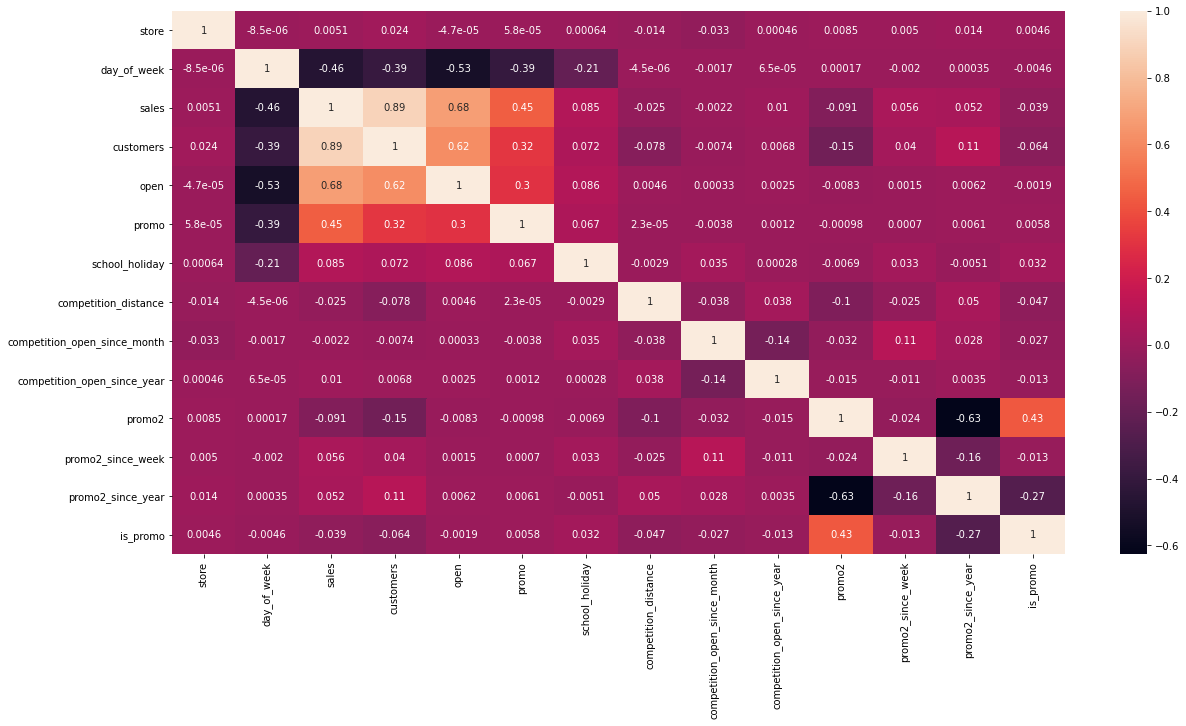

In [110]:
correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True )

## 4.3.2. Categorical Attributes

In [111]:
a = df4.select_dtypes( include='object')

In [112]:
a.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extendend,2015-30
4,regular_day,a,basic,2015-30


In [113]:
pd.crosstab( a['state_holiday'], a['store_type'] )

store_type,a,b,c,d
state_holiday,,,,
christmas,4,66,0,1
easter_holiday,36,100,0,9
public_holiday,236,285,65,108
regular_day,456766,15109,112903,258650


In [114]:
cm = pd.crosstab( a['state_holiday'], a['store_type'] ).values

In [115]:
chi2 = ss.chi2_contingency( cm )[0]

In [116]:
chi2

12792.159524019908

In [117]:
n = cm.sum()

r, k = cm.shape

In [118]:
v = np.sqrt( (chi2/n) / ( min( k-1,r-1 ) ) ) 

In [119]:
v

0.07106457093267678

In [120]:
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    
    return np.sqrt( (chi2/n) / ( min( k-1, r-1 ) ) )

In [121]:
cramer_v( a['state_holiday'], a['store_type'] )

0.07106457093267678

In [122]:
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k= cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min(kcorr-1, rcorr-1 ) ) )

In [123]:
cramer_v( a['state_holiday'], a['store_type'] )

0.07106469715258833

In [125]:
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

d = pd.DataFrame( {'state_holiday': [a1,a2,a3],
                      'store_type': [a4,a5,a6],
                      'assortment': [a7,a8,a9] })

d = d.set_index( d.columns )

In [126]:
d

,state_holiday,store_type,assortment
state_holiday,1.000002,0.071065,0.067546
store_type,0.071065,1.000002,0.538457
assortment,0.067546,0.538457,1.000001


<AxesSubplot:>

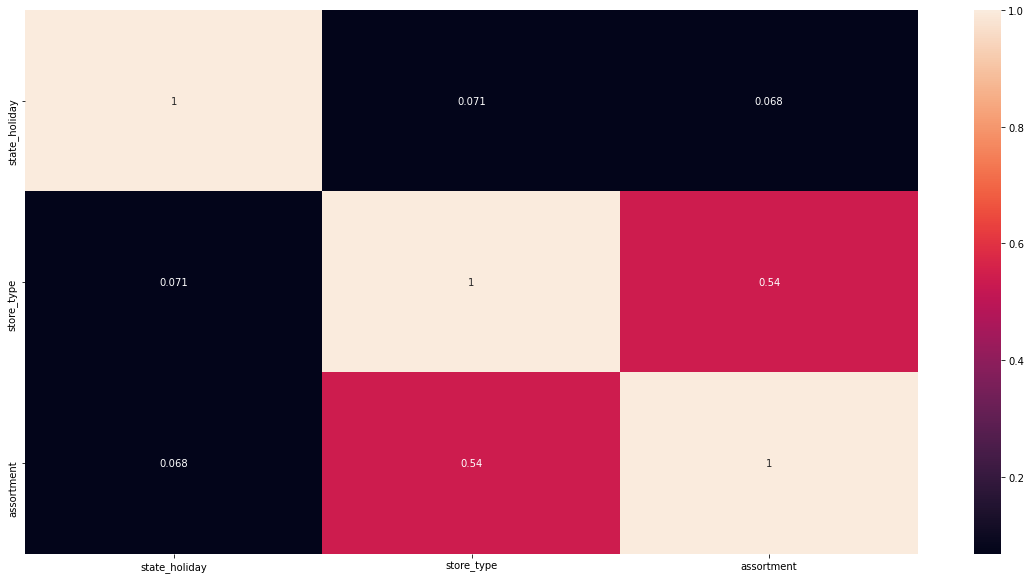

In [127]:
sns.heatmap( d, annot=True )

# 5.0. PASSO 05 - DATA PREPARATION

## 5.1. Normalização:

## 5.2. Rescaling:

In [128]:
df5 = df4.copy()

In [129]:
a = df5.select_dtypes( include=['int64','float64'] )

In [130]:
a.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,week_of_year,day
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,2015,7,31,31
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,2015,7,31,31
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,2015,7,31,31
3,4,5,13995,1,1,620.0,9,2009,0,31,2015,0,2015,7,31,31
4,5,5,4822,1,1,29910.0,4,2015,0,31,2015,0,2015,7,31,31


<AxesSubplot:xlabel='competition_distance'>

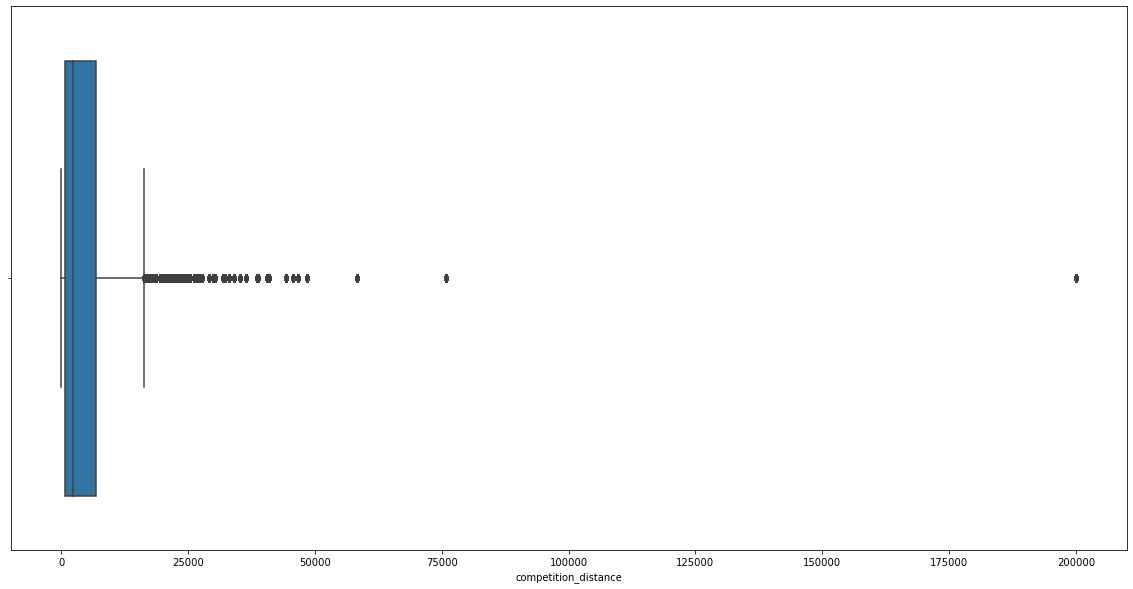

In [131]:
# competition distance

sns.boxplot( df5['competition_distance'] )
#plt.rcParams["figure.size"]=(10,10)

In [132]:
rs = RobustScaler()
mns = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )

<AxesSubplot:xlabel='competition_time_month'>

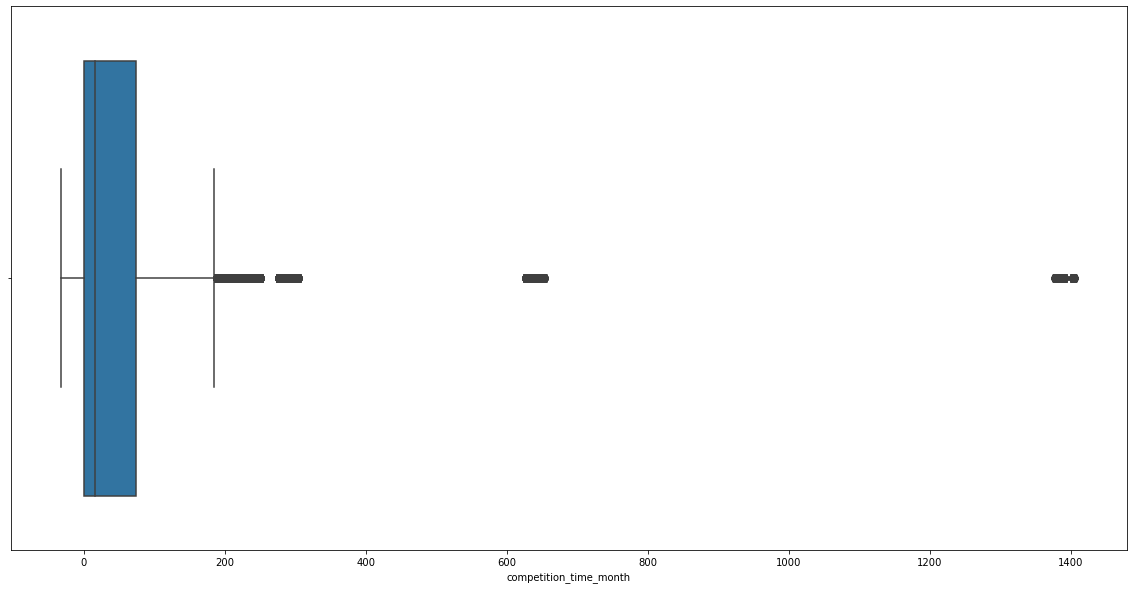

In [133]:
# competition time month

sns.boxplot( df5['competition_time_month'] )
#plt.rcParams["figure.size"]=(10,10)

In [134]:
# competition time month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )

<AxesSubplot:xlabel='promo_time_week'>

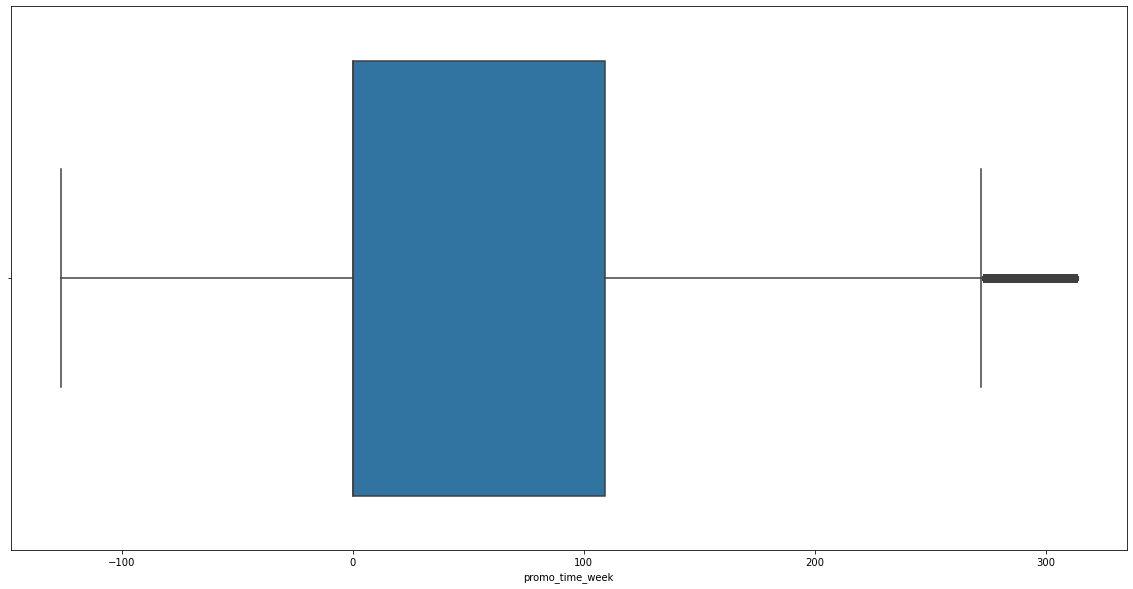

In [135]:
# promo time week

sns.boxplot( df5['promo_time_week'] )
#plt.rcParams["figure.size"]=(10,10)

In [136]:
df5['promo_time_week'] = mns.fit_transform( df5[['promo_time_week']].values )

<AxesSubplot:xlabel='year'>

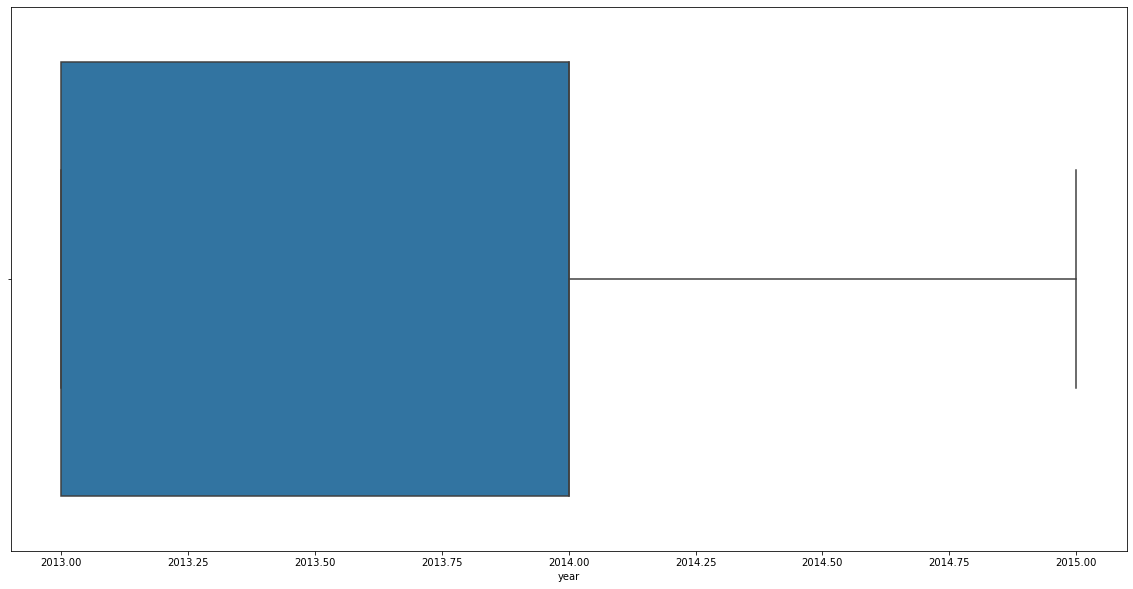

In [137]:
sns.boxplot( df5['year'] )
#plt.rcParams["figure.size"]=(10,10)

In [138]:
df5['year'] = mns.fit_transform( df5[['year']].values )

## 5.3. Transformação:

## 5.3.1. Encoding

In [139]:
df5.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,is_promo,year,month,week_of_year,day,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,-0.170968,...,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,-0.283871,...,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,1.903226,...,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822
3,4,5,2015-07-31,13995,1,regular_day,1,c,extendend,-0.275806,...,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,4.448387,...,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016


In [140]:
# state_holiday - "One hot encoding"

df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

In [141]:
# store_type - "Label encoding"

le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )

In [142]:
# assortment - "Ordinal encoding"

assortment_dict = { 'basic': 1, 'extra': 2, 'extendend': 3 }
df5['assortment'] = df5['assortment'].map( assortment_dict )

In [143]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,day,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,1,1,2,1,-0.170968,9,...,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1
1,2,5,2015-07-31,6064,1,1,0,1,-0.283871,11,...,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1
2,3,5,2015-07-31,8314,1,1,0,1,1.903226,12,...,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1
3,4,5,2015-07-31,13995,1,1,2,3,-0.275806,9,...,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1
4,5,5,2015-07-31,4822,1,1,0,1,4.448387,4,...,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1


## 5.3.2. Response Variable Transformation

<AxesSubplot:xlabel='sales', ylabel='Density'>

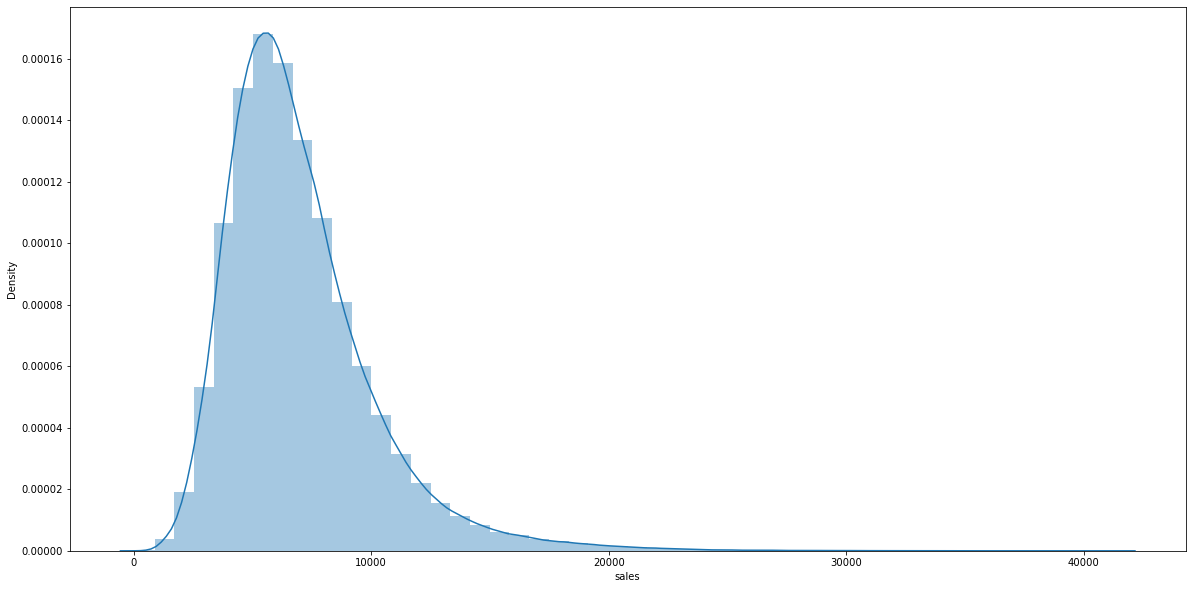

In [144]:
sns.distplot( df5['sales'] )

In [145]:
df5['sales'] = np.log1p( df5['sales'] )

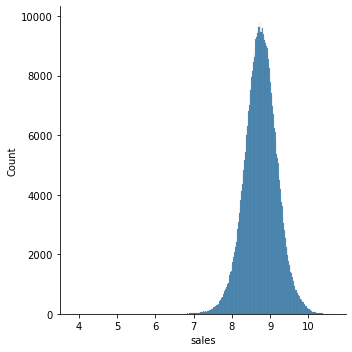

In [146]:
sns.displot( df5['sales'] )

## 5.3.2. Nature transformation

In [147]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * (2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * (2. * np.pi/7 ) ) )

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * (2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * (2. * np.pi/12 ) ) ) 

# day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * (2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * (2. * np.pi/30 ) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * (2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * (2. * np.pi/52 ) ) )

In [148]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


# 6.0. PASSO 06 - FEATURE SELECTION

In [149]:
df6 = df5.copy()

## 6.1. Split dataframe into training and test dataset

In [150]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop( cols_drop, axis=1 )

In [151]:
# first day of sales each store:

df6[['store', 'date']].groupby( 'store' ).min().reset_index()

,store,date
0,1,2013-01-02
1,2,2013-01-02
2,3,2013-01-02
3,4,2013-01-02
4,5,2013-01-02
...,...,...
1110,1111,2013-01-02
1111,1112,2013-01-02
1112,1113,2013-01-02
1113,1114,2013-01-02


In [152]:
df6[['store', 'date']].groupby( 'store' ).min().reset_index()['date'][0]

Timestamp('2013-01-02 00:00:00')

In [153]:
# Last day of sales each store:

df6[['store', 'date']].groupby( 'store' ).max().reset_index()

,store,date
0,1,2015-07-31
1,2,2015-07-31
2,3,2015-07-31
3,4,2015-07-31
4,5,2015-07-31
...,...,...
1110,1111,2015-07-31
1111,1112,2015-07-31
1112,1113,2015-07-31
1113,1114,2015-07-31


In [154]:
df6[['store', 'date']].groupby( 'store' ).max().reset_index()['date'][0]

Timestamp('2015-07-31 00:00:00')

In [155]:
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta( days = 6 * 7 )

Timestamp('2015-06-19 00:00:00')

In [156]:
# training dataset

X_train = df6[df6['date'] < '2015-06-19' ]
y_train = X_train['sales']

# test dataset

X_test = df6[df6['date'] >= '2015-06-19' ]
y_test = X_test['sales']

print( 'Training Min Date: {}'.format ( X_train['date'].min() ) )
print( 'Training Max Date: {}'.format ( X_train['date'].max() ) )

print(   '\nTest Min Date: {}'.format ( X_test ['date'].min() ) )
print(     'Test Max Date: {}'.format ( X_test ['date'].max() ) )

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2. Boruta as Feature Selector

In [159]:
# training and test dataset for Boruta
X_train_n = X_train.drop( [ 'date','sales' ], axis=1 ).values
y_train_n = y_train.values.ravel()

# define RandomForestRegressor
rf= RandomForestRegressor( n_jobs= -1 )

# define Boruta
boruta = BorutaPy ( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_n, y_train_n )

KeyboardInterrupt: 

## 6.2.1. Best features from Boruta

In [158]:
cols_selected = boruta.support_.tolist()

# best features
X_train_fs = X_train.drop( ['date','sales'], axis=1 )
cols_selected_boruta = X_train_fs.iloc[ :, cols_selected ].columns.to_list()

# not select boruta
cols_not_select_boruta = list( np.setdiff1d( X_train_fs.columns,cols_selected_boruta ) ) 

NameError: name 'boruta' is not defined

## 6.3. Manual Feature Selection 

In [165]:
# Features irelevant
    
cols_selected_boruta = [
 'store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos']

cols_not_select_boruta = [
'is_promo',
'month_sin',
'school_holiday',
'state_holiday_christmas',
'state_holiday_easter_holiday',
'state_holiday_public_holiday',
'state_holiday_regular_day',
'week_of_year_sin',
'year']


# columns to add
feat_to_add = ['date','sales']

# final features
cols_selected_boruta_full = cols_selected_boruta.copy()

cols_selected_boruta_full.extend( feat_to_add ) 

In [161]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos']

In [162]:
cols_not_select_boruta

['is_promo',
 'month_sin',
 'school_holiday',
 'state_holiday_christmas',
 'state_holiday_easter_holiday',
 'state_holiday_public_holiday',
 'state_holiday_regular_day',
 'week_of_year_sin',
 'year']

# 7.0. PASSO 07 - MACHINE LEARNING MODELLING


In [163]:
x_train = X_train[ cols_selected_boruta ]
x_test  = X_test[ cols_selected_boruta ]

# Time Series Data Preparation
x_training = X_train[ cols_selected_boruta_full ]

## 7.1 Average Model

In [169]:
def m1_error( model_name, y, yhat ):
    mae  = mean_absolute_error(y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt (mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( { 'Model Name': model_name,
                           'MAE': mae,
                           'MAPE': mape,
                           'RMSE': rmse }, index=[0] )

In [170]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby( 'store' ).mean().reset_index().rename( columns= {'sales' : 'predictions'} )
aux1= pd.merge( aux1, aux2, how='left', on='store' )
yhat_baseline = aux1['predictions']
             
# performace
baseline_result= m1_error( 'Average Model', np.expm1( y_test ), np.expm1( yhat_baseline ) )
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.2064,1835.135542


## 7.2 Linear Regression Model

In [171]:
# model
lr = LinearRegression().fit( x_train, y_train )

# prediction
yhat_lr = lr.predict( x_test )

# performace
lr_result = m1_error( 'Linear Regression', np.expm1( y_test ), np.expm1( yhat_lr ) )
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


### 7.2.1 Linear Regression Model - Cross Validation

In [172]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose=False )

In [173]:
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73+/-295.63,0.3+/-0.02,2952.52+/-468.37


## 7.3 Linear Regression Regularized Model  - Lasso 

In [174]:
# model
lrr = Lasso( alpha=0.01 ).fit( x_train, y_train )

# prediction
yhat_lrr = lrr.predict( x_test )

# performace
lrr_result = m1_error( 'Linear Regression - Lasso', np.expm1( y_test ), np.expm1( yhat_lrr ))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


### 7.3.1 Linear Regression Regularized Model - Lasso - Cross validation

In [175]:
lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lr, verbose=False )
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2081.73+/-295.63,0.3+/-0.02,2952.52+/-468.37


## 7.4 Random Forest Regressor

In [176]:
# model
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit( x_train, y_train )

# prediction
yhat_rf = rf.predict( x_test )

# performace
rf_result = m1_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf ) )
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.598831,0.099913,1011.119437


### 7.4.1 Random Forest Regressor - Cross validation

In [177]:
rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose=True )
rf_result_cv


 KFold Number: 5

 KFold Number: 4

 KFold Number: 3

 KFold Number: 2

 KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,836.61+/-217.1,0.12+/-0.02,1254.3+/-316.17


## 7.5 XGBoost Regressor

In [180]:
# model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimatos=100,
                              eta=0.01,
                              max_depth=10,
                              subsample=0.7,
                              colsample_bytee=0.09 ).fit( x_train, y_train )

# prediction
yhat_xgb = model_xgb.predict( x_test )

# performace
xgb_result = m1_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )
xgb_result

[20:19:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "colsample_bytee", "n_estimatos" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,6683.6064,0.949503,7330.742181


### 7.5.1 XGBoost Regressor - Cross validation

In [178]:
import warnings
warnings.filterwarnings( 'ignore' )

In [181]:
xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
xgb_result_cv


 KFold Number: 5
[20:21:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "colsample_bytee", "n_estimatos" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.



 KFold Number: 4
[20:22:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "colsample_bytee", "n_estimatos" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.



 KFold Number: 3
[20:23:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "colsample

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,7047.97+/-587.65,0.95+/-0.0,7714.03+/-688.72


## 7.6 Compare Madel's Performace

## 7.6.1 Single Performace

In [182]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result ] )
modelling_result.sort_values( 'RMSE' )

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.598831,0.099913,1011.119437
0,Average Model,1354.800353,0.206400,1835.135542
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737
0,XGBoost Regressor,6683.606400,0.949503,7330.742181


## 7.6.2 Real Performace - Cross validation

In [176]:
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv ] )
modelling_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73+/-295.63,0.3+/-0.02,2952.52+/-468.37
0,Lasso,2081.73+/-295.63,0.3+/-0.02,2952.52+/-468.37
0,Random Forest Regressor,836.61+/-217.1,0.12+/-0.02,1254.3+/-316.17
0,XGBoost Regressor,7047.97+/-587.65,0.95+/-0.0,7714.03+/-688.72


 # 8.0. PASSO 08 - HYPERPARAMETER FINE TUNNING


## 8.1. Random Search

In [183]:
param = {
        
        'n_estimators': [1500, 1700, 2500, 3000, 3500],
        'eta': [0.01, 0.03],
        'max_depth': [3, 5, 9],
        'subsample': [0.1, 0.5, 0.7],
        'colsample_bytee':[0.3, 0.7, 0.9],
        'min_child_weight': [3, 8, 15]
              
       }

MAX_EVAL = 10

In [184]:
final_result = pd.DataFrame()

for i in range( MAX_EVAL ):
   # choose values for parameters randomly
   hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
   print ( hp ) 


# model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators=hp['n_estimators'],
                              eta=hp['eta'],
                              max_depth=hp['max_depth'],
                              subsample=hp['subsample'],
                              colsample_bytee=hp['colsample_bytee'],
                              min_child_weight=hp['min_child_weight'] )

# performace
result = cross_validation( x_training, 2, 'XGBoost Regressor', model_xgb, verbose=False )
final_result = pd.concat( [final_result, result] ) 

final_result


{'n_estimators': 3000, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytee': 0.9, 'min_child_weight': 15}
{'n_estimators': 2500, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytee': 0.3, 'min_child_weight': 15}
{'n_estimators': 3500, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.5, 'colsample_bytee': 0.7, 'min_child_weight': 3}
{'n_estimators': 3500, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.1, 'colsample_bytee': 0.9, 'min_child_weight': 8}
{'n_estimators': 1700, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytee': 0.7, 'min_child_weight': 8}
{'n_estimators': 2500, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytee': 0.7, 'min_child_weight': 8}
{'n_estimators': 3500, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytee': 0.7, 'min_child_weight': 3}
{'n_estimators': 1700, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.5, 'colsample_bytee': 0.7, 'min_child_weight': 15}
{'n_estimators': 3000, 'eta': 0.03, 'max_depth': 3, 'subsampl

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,915.38+/-77.7,0.12+/-0.01,1312.83+/-133.35


## 8.2 Final Model

In [185]:
param_tuned = {
        
        'n_estimators': 30,
        'eta': 0.03,
        'max_depth': 9,
        'subsample': 0.1,
        'colsample_bytee': 0.7,
        'min_child_weight': 15 
              
       }


In [186]:
# model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                                    n_estimators=param_tuned['n_estimators'],
                                    eta=param_tuned['eta'],
                                    max_depth=param_tuned['max_depth'],
                                    subsample=param_tuned['subsample'],
                                    colsample_bytee=param_tuned['colsample_bytee'],
                                    min_child_weight=param_tuned['min_child_weight'] ).fit( x_train, y_train )

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# performace
result = m1_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1(yhat_xgb_tuned ) )
xgb_result_tuned = m1_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )

final_result

[21:23:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "colsample_bytee" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,915.38+/-77.7,0.12+/-0.01,1312.83+/-133.35


In [189]:
yhat_xgb_tuned

array([5.557899 , 5.5355167, 5.556632 , ..., 5.5333805, 5.566475 ,
       5.4933434], dtype=float32)

 # 9.0. PASSO 09 - TRADUCAO E INTERPRETACAO DO ERRO


In [188]:
df9 = X_test[ cols_selected_boruta_full ]

# rescale (Dados de treino e teste estão em escala logaritmíca )

df9[ 'sales' ] = np.expm1( df9[ 'sales' ] )
df9[ 'predictions' ] = np.expm1( yhat_xgb_tuned )

 ## 9.1. Business Performance


In [233]:
# sum of predictions 
df91 = df9[['store', 'predictions']].groupby( 'store' ).sum().reset_index()

# MAE
df9_aux1 = df9[[ 'store', 'sales', 'predictions' ]].groupby( 'store' ).apply( lambda x: mean_absolute_error( x[ 'sales' ], x[ 'predictions' ] ) ).reset_index().rename( columns={ 0: 'MAE'})

# MAPE
df9_aux2 = df9[[ 'store', 'sales', 'predictions' ]].groupby( 'store' ).apply( lambda x: mean_absolute_percentage_error(x[ 'sales' ], x[ 'predictions' ] ) ).reset_index().rename( columns= { 0: 'MAPE'} )

# MERGE df9_aux1 and df9_aux2

df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store' )
df92 = pd.merge( df91, df9_aux3, how='inner', on='store' )


# Scenarios

df92[ 'worst_scenario'] = df92[ 'predictions' ] - df92[ 'MAE' ]
df92[ 'best_scenario' ] = df92[ 'predictions' ] + df92[ 'MAPE' ]

# Order colums

df92 = df92[[ 'store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE' ]]

In [234]:
# Apresentando dados com 4 algarismo após a vírgula:
pd.set_option('display.float_format', lambda x: '%.4f' % x)

df92.head()


,store,predictions,worst_scenario,best_scenario,MAE,MAPE
0,1,8476.7920,4318.8675,8477.7393,4157.9245,0.9473
1,2,7973.2974,3244.5757,7974.2514,4728.7217,0.9541
2,3,8170.6099,1521.4372,8171.5764,6649.1727,0.9665
3,4,9200.5693,-533.9558,9201.5439,9734.5252,0.9746
4,5,7451.9023,3142.3592,7452.8547,4309.5432,0.9524


In [235]:
df92.sort_values( 'MAPE', ascending= False ).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
816,817,8821.6074,-11799.6464,8822.5957,20621.2539,0.9883
1113,1114,9891.8311,-12617.1465,9892.8191,22508.9775,0.9881
261,262,10763.4463,-10177.7759,10764.4341,20941.2222,0.9878
841,842,9201.5518,-10919.9468,9202.5393,20121.4986,0.9875
512,513,8671.2832,-8126.7632,8672.2693,16798.0464,0.9861


<AxesSubplot:xlabel='store', ylabel='MAPE'>

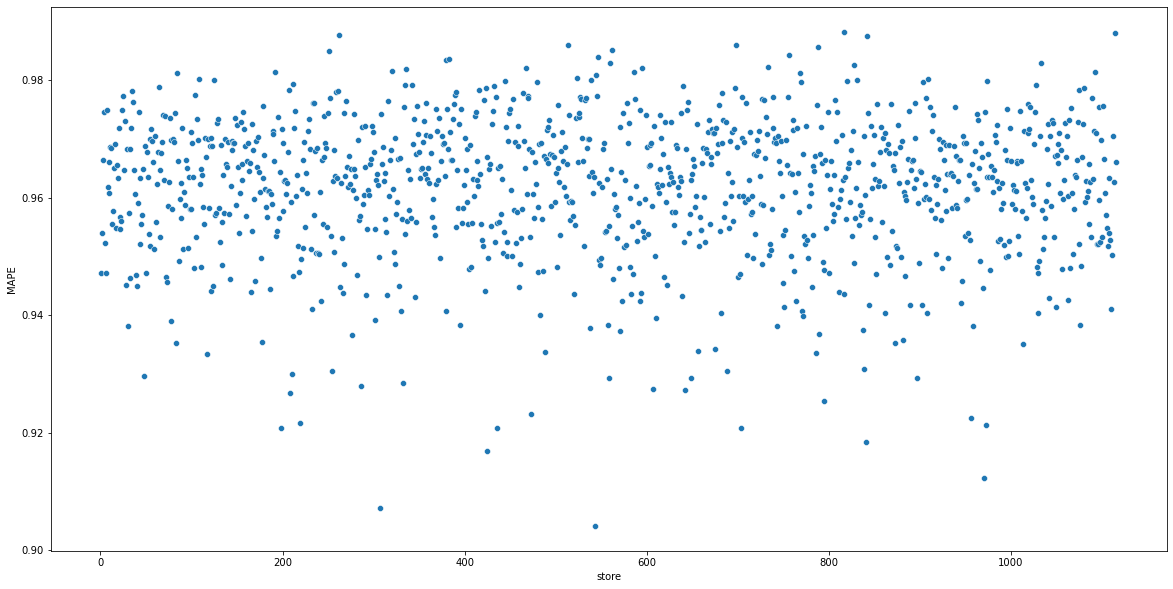

In [237]:
sns.scatterplot( x='store', y='MAPE', data=df92 )

 ## 9.2. Total Performance

In [251]:
df93 = df92[[ 'predictions', 'worst_scenario', 'best_scenario' ]].apply( lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns= {'index':'Scenarios', 0:'Values'}) 
df93[ 'Values' ] = df93[ 'Values' ].map( 'R${:,.2f}'.format)

df93

,Scenarios,Values
0,predictions,"R$9,596,452.00"
1,worst_scenario,"R$2,062,645.89"
2,best_scenario,"R$9,597,525.00"


 ## 9.3.Machine Learning Performance

In [253]:
df9[ 'error' ] = df9[ 'sales' ] - df9[ 'predictions' ]

df9[ 'error_rate' ] = df9[ 'predictions' ] / df9[ 'sales' ]

<AxesSubplot:xlabel='predictions', ylabel='error'>

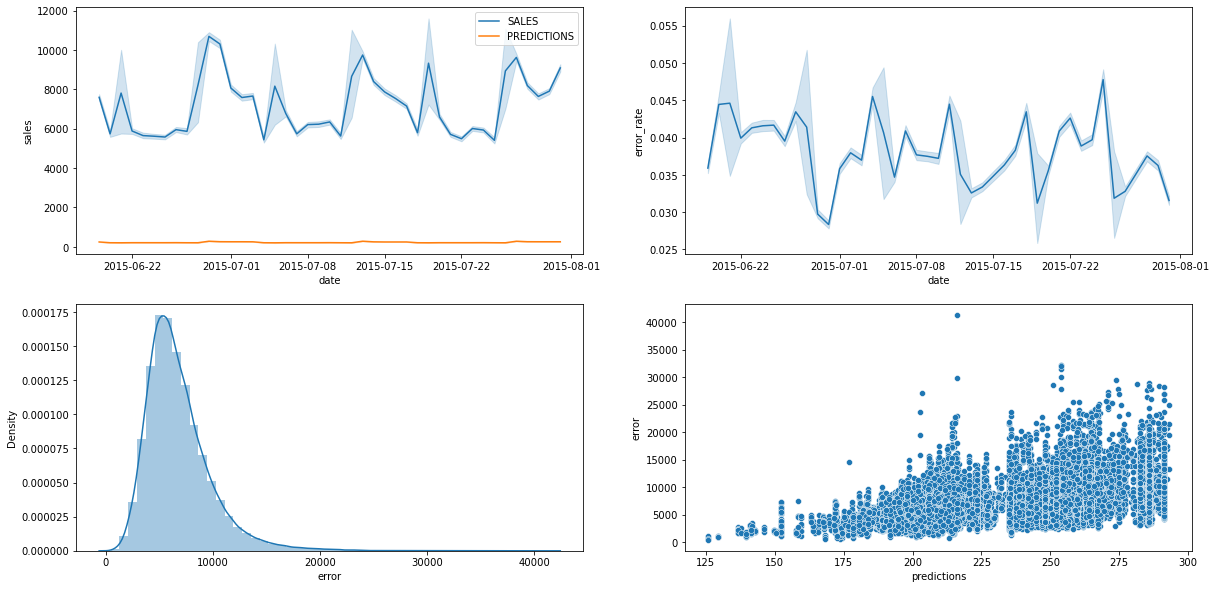

In [255]:
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='SALES' )
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' )

plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9 )

plt.subplot( 2, 2, 3 )
sns.distplot( df9[ 'error' ] )

plt.subplot( 2, 2, 4 )
sns.scatterplot(df9[ 'predictions' ], df9[ 'error' ] )

In [156]:
# ( x_train dataset without date and sales columns )

x_train.head()

,store,promo,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,competition_time_month,promo_time_week,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
47945,1,1,2,1,-0.170968,9,2008,0,25,2015,0.891892,0.287016,-0.433884,-0.900969,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709
47946,2,1,0,1,-0.283871,11,2007,1,13,2010,1.027027,0.908884,-0.433884,-0.900969,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709
47947,3,1,0,1,1.903226,12,2006,1,14,2011,1.189189,0.788155,-0.433884,-0.900969,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709
47948,4,1,2,3,-0.275806,9,2009,0,25,2015,0.729730,0.287016,-0.433884,-0.900969,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709
47949,5,1,0,1,4.448387,4,2015,0,25,2015,-0.189189,0.287016,-0.433884,-0.900969,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709


In [157]:
# ( X_train dataset complete )

X_train.head()

,store,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,...,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
47945,1,2015-06-18,8.443762,1,0,2,1,-0.170968,9,2008,...,0,1,-0.433884,-0.900969,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709
47946,2,2015-06-18,8.547722,1,0,0,1,-0.283871,11,2007,...,0,1,-0.433884,-0.900969,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709
47947,3,2015-06-18,8.927712,1,0,0,1,1.903226,12,2006,...,0,1,-0.433884,-0.900969,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709
47948,4,2015-06-18,9.091669,1,0,2,3,-0.275806,9,2009,...,0,1,-0.433884,-0.900969,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709
47949,5,2015-06-18,8.502080,1,0,0,1,4.448387,4,2015,...,0,1,-0.433884,-0.900969,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709


In [160]:
x_training = X_train[ cols_selected_boruta_full ]

In [162]:
x_training.head()

,store,promo,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,...,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,date,sales
47945,1,1,2,1,-0.170968,9,2008,0,25,2015,...,-0.433884,-0.900969,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,2015-06-18,8.443762
47946,2,1,0,1,-0.283871,11,2007,1,13,2010,...,-0.433884,-0.900969,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,2015-06-18,8.547722
47947,3,1,0,1,1.903226,12,2006,1,14,2011,...,-0.433884,-0.900969,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,2015-06-18,8.927712
47948,4,1,2,3,-0.275806,9,2009,0,25,2015,...,-0.433884,-0.900969,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,2015-06-18,9.091669
47949,5,1,0,1,4.448387,4,2015,0,25,2015,...,-0.433884,-0.900969,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,2015-06-18,8.502080


In [165]:
# Last date of sale - "2015-06-18"

x_training[ 'date' ].max()

Timestamp('2015-06-18 00:00:00')

In [169]:
# First date of sale - "2013-01-01"
x_training[ 'date' ].min()

Timestamp('2013-01-01 00:00:00')

In [152]:
for k in reversed( range ( 1, 6) ):
    print(k)

5
4
3
2
1


In [173]:
# '2015-05-06 00:00:00'

training[ 'date' ].max()

Timestamp('2015-05-06 00:00:00')

In [175]:
# '2013-01-01 00:00:00'

training[ 'date' ].min()

Timestamp('2013-01-01 00:00:00')

In [176]:
# '2015-06-18 00:00:00'

validation[ 'date' ].max()

Timestamp('2015-06-18 00:00:00')

In [178]:
# '2015-05-07 00:00:00'

validation[ 'date' ].min()

Timestamp('2015-05-07 00:00:00')

In [157]:
x_training = X_train[ cols_selected_boruta_full]

In [162]:
model = LinearRegression()
a = cross_validation( x_training, 5, 'Linear Regression', model )

In [163]:
a

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73+/-295.63,0.3+/-0.02,2952.52+/-468.37


In [165]:
model = Lasso( alpha=0.01 )
a = cross_validation( x_training, 5, 'Lasso', model )

In [166]:
a

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38+/-341.5,0.29+/-0.01,3057.75+/-504.26
